# Case 5 

> In this case study, we are exploring deep learning interpretability on BSI prognosis, before, during and after training a CNN model on multi-variate time series medical record.
 
> we use hourly aggregated physiological data and lab results from 10,000 ICU patients. 1824 positive events and 31496 control group events are generated from the population. 

> we use 25 features selected by domain knowledge, 96 hours prior to the blood culture acquisition to classify positive test results from the control group -- negative test results and 4 days of randomly sliced baseline patient data.  


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd'

# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
print(bsi_stream.engineer.variable_dict)
print(bsi_stream.engineer.csv_source_dict)

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.
{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'], 'label': 'subject id', 'unique_per_sbj': True}, '__time': {'src_names': ['tsa', 'timeMinutes'], 'label': 'Time since admission', 'unit': 'minute'}, '__anchor': {'src_names': ['True_positive', 'True positive'], 'label': 'episode anchor', 'unique_per_sbj': False, 'factor': {'levels': {'__nbc': ['nan'], '__neg': ['0', '0.0'], '__pos': ['1', '1.0']}, 'impute_per_sbj': {'nan_level': '__nbc'}}}, 'y': {'output': True, 'src_names': ['True_positive', 'True positive'], 'label': 'Blood culture result', 'unique_per_sbj': False, '

In [3]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1*24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

Success! Engineer has updated attributes --- episode. 


In [ ]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 6000, # number of subjects / patients to sample from the pool 
                              replace=False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median',
                              sep="_", 
                              return_episode=True)# imputation on response (no need in BSI project)


Engineer is sampling without replacement --- 
6000---out of---11143---subjects are sampled from csv pool of size---31565
-- __time fixed
--- fix upper boundary for age by 90.0
--- fix lower boundary for age by 14.106278416609644
-- age fixed
--- fix upper boundary for albumin by 5.0
--- fix lower boundary for albumin by 1.0
-- albumin fixed
--- fix upper boundary for alp by 800.0
--- fix lower boundary for alp by 12.0
-- alp fixed
--- fix upper boundary for alt by 1085.0
--- fix lower boundary for alt by 6.0
-- alt fixed
--- fix upper boundary for ast by 1300.0
--- fix lower boundary for ast by 5.0
-- ast fixed
--- fix upper boundary for bicarbonate by 60.0
--- fix lower boundary for bicarbonate by 4.1
-- bicarbonate fixed
--- fix upper boundary for bun by 150.0
--- fix lower boundary for bun by 2.0
-- bun fixed
--- fix upper boundary for calcium by 12.7
--- fix lower boundary for calcium by 4.8
-- calcium fixed
--- fix upper boundary for chloride by 140.0
--- fix lower boundary for ch

-- __time fixed
--- fix upper boundary for dbp by 144.0
--- fix lower boundary for dbp by 26.0
-- dbp fixed
--- fix upper boundary for fio2_pct by 100.0
--- fix lower boundary for fio2_pct by 21.0
-- fio2_pct fixed
--- fix upper boundary for heart_rate by 185.0
--- fix lower boundary for heart_rate by 30.0
-- heart_rate fixed
--- fix upper boundary for o2_flow by 80.0
--- fix lower boundary for o2_flow by 0.0
-- o2_flow fixed
--- fix upper boundary for peep by 32.0
--- fix lower boundary for peep by 0.0
-- peep fixed
--- fix upper boundary for resp_rate by 66.0
--- fix lower boundary for resp_rate by 6.0
-- resp_rate fixed
--- fix upper boundary for sbp by 237.0
--- fix lower boundary for sbp by 48.0
-- sbp fixed
--- fix upper boundary for spo2 by 100.0
--- fix lower boundary for spo2 by 79.0
-- spo2 fixed
--- fix upper boundary for temp by 104.0
--- fix lower boundary for temp by 80.0
-- temp fixed
-- __time fixed
-- __anchor fixed
-- y fixed
--- fix variable dtype for age --- failed.

In [5]:
all_df = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df = pd.concat( [all_df, bsi_stream.engineer.test_df], axis=0)
print(len(set(all_df.__uid)))
all_df.describe() 
all_df.to_csv("./whole_df_fwd.csv", index=False)

1000


age       albumin           alp           alt           ast  \
count  175464.000000  71424.000000  71401.000000  69887.000000  70488.000000   
mean       57.975783      2.757574    145.536871     60.954292     71.542090   
std        16.800403      0.622469    137.813745    128.881009    142.336078   
min        15.783643      0.800000     12.000000      6.000000      6.000000   
25%        47.923839      2.300000     69.000000     15.000000     21.000000   
50%        59.560475      2.700000    102.000000     26.000000     34.000000   
75%        69.380447      3.200000    160.000000     54.000000     65.000000   
max        90.000000      5.000000    800.000000   1085.000000   1300.000000   

        bicarbonate           bun       calcium      chloride           co2  \
count  62157.000000  91617.000000  91617.000000  91617.000000  91596.000000   
mean      25.030813     31.660437      8.454521    104.906261     24.224547   
std        5.604726     23.373108      0.817892      6.648888      4.973447   
min        4.100000      2.000000      4.800000     76.000000      6.000000   
25%       21.600000     15.000000      7.900000    101.000000     21.000000   
50%       24.600000     25.000000      8.400000    105.000000     24.000000   
75%       28.300000     41.000000      8.900000    109.000000     27.000000   
max       52.900000    143.000000     13.700000    136.000000     40.000000   

         creatinine           dbp      fio2_pct       glucose    hematocrit  \
count  91617.000000  94450.000000  73174.000000  92285.000000  92164.000000   
mean       1.541062     66.465896     37.582863    136.133397     29.127680   
std        1.476228     13.152108     20.686008     51.349797      5.454855   
min        0.300000     20.000000     21.000000     40.000000     13.300000   
25%        0.700000     57.000000     21.000000    104.000000     25.300000   
50%        1.000000     65.000000     35.000000    125.000000     28.100000   
75%        1.700000     75.000000     40.000000    152.000000     32.000000   
max       10.000000    150.000000    100.000000    500.000000     58.000000   

         hemoglobin    heart_rate   lactic_acid     magnesium       o2_flow  \
count  92168.000000  50346.000000  56367.000000  87043.000000  76277.000000   
mean       9.497711     90.775172      1.667861      1.988388      8.321176   
std        1.867580     18.170781      1.454768      0.346978     14.955459   
min        4.100000     39.443109      0.300000      0.900000      0.000000   
25%        8.200000     77.220856      1.000000      1.800000      0.000000   
50%        9.100000     89.554315      1.300000      2.000000      2.500000   
75%       10.400000    102.904788      1.800000      2.200000      6.000000   
max       19.700000    168.532527     19.100000      5.000000     80.000000   

               pco2          peep   ph_arterial    phosphorus           po2  \
count  62241.000000  36095.000000  62241.000000  87500.000000  62342.000000   
mean      40.977408      7.146096      7.404449      3.469224    103.159829   
std        9.912870      3.086578      0.077137      1.255823     60.916031   
min       10.000000      0.000000      6.863000      0.800000     19.400000   
25%       34.600000      5.000000      7.359000      2.600000     71.300000   
50%       39.700000      7.000000      7.413000      3.300000     88.300000   
75%       45.800000      8.000000      7.460000      4.100000    112.700000   
max      100.500000     40.000000      7.639000     10.000000    575.500000   

          potassium   protime_inr           ptt     resp_rate           sbp  \
count  92062.000000  80596.000000  75063.000000  44766.000000  94450.000000   
mean       3.961327      1.384774     34.588431     21.978515    124.825082   
std        0.539128      0.514614     14.877375      6.900730     22.862782   
min        1.800000      0.800000     20.100000      5.000000     40.000000   
25%        3.600000      1.100000     26.900000     1

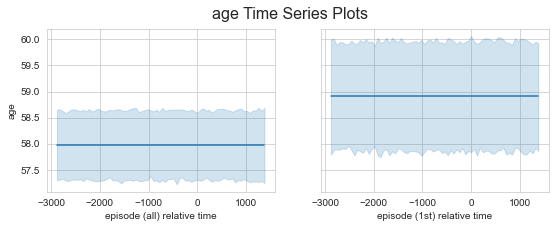

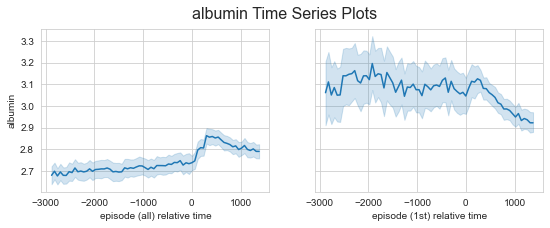

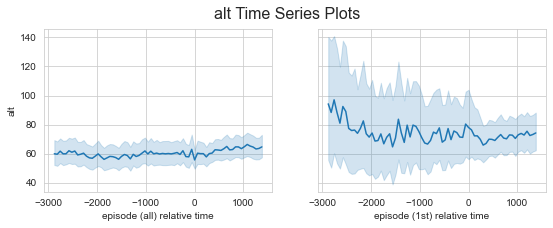

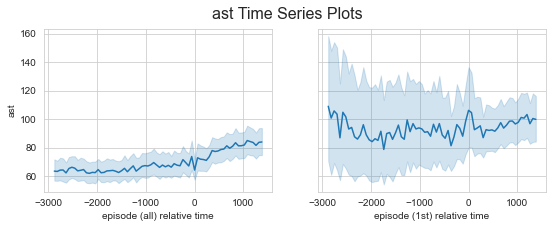

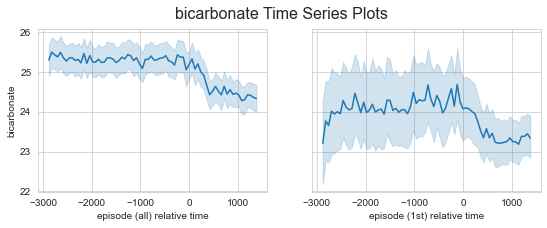

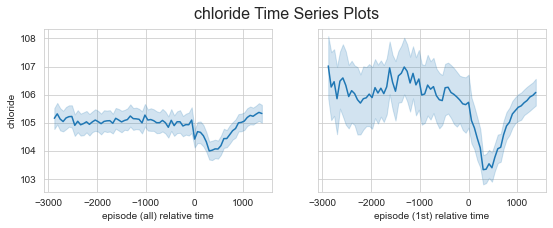

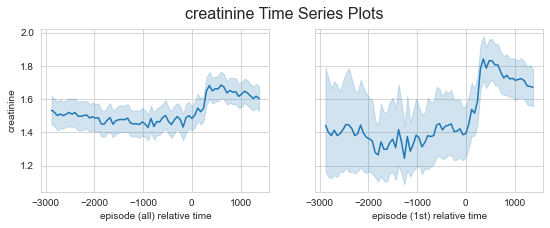

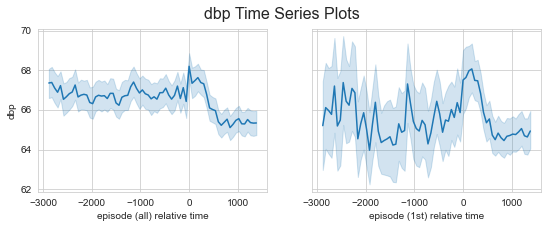

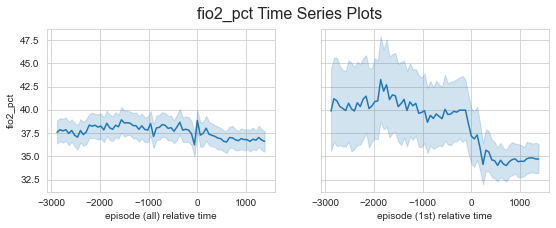

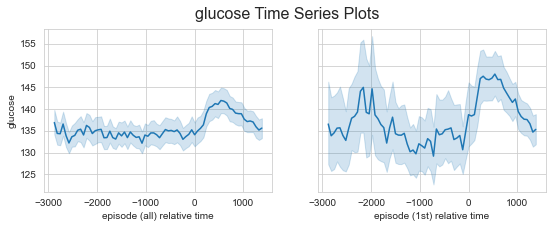

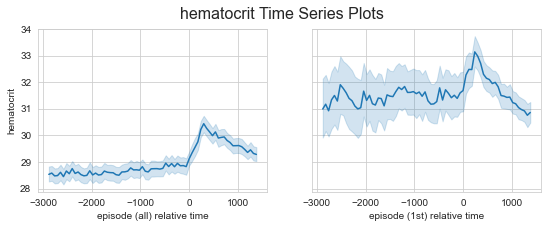

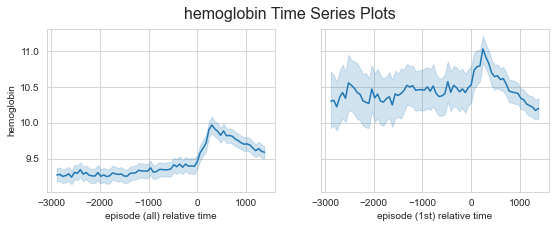

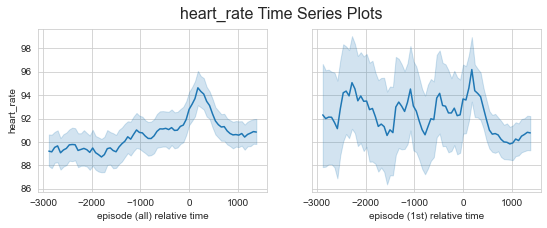

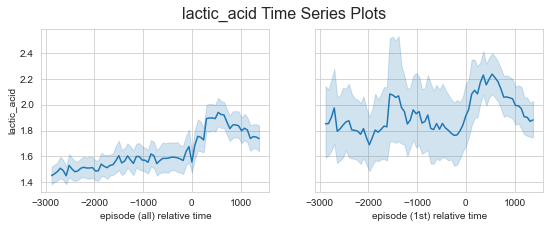

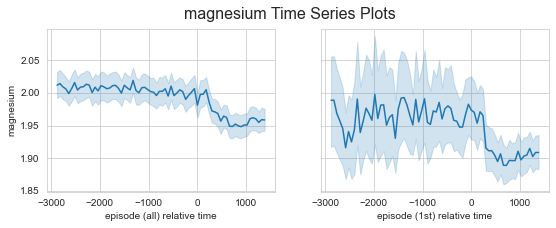

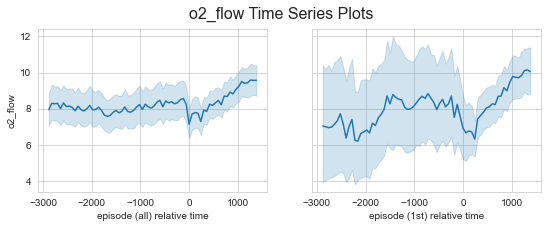

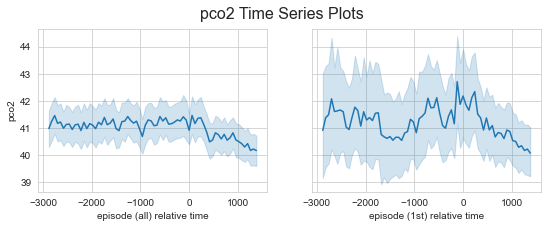

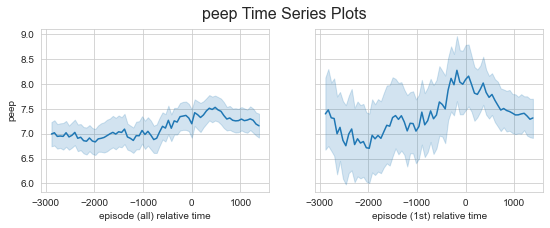

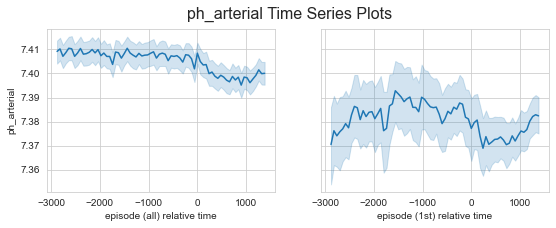

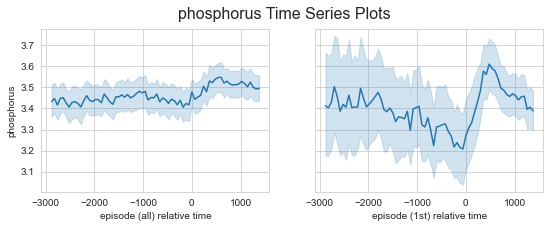

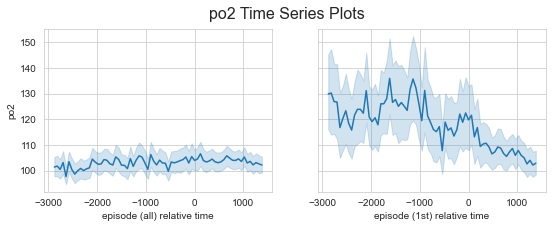

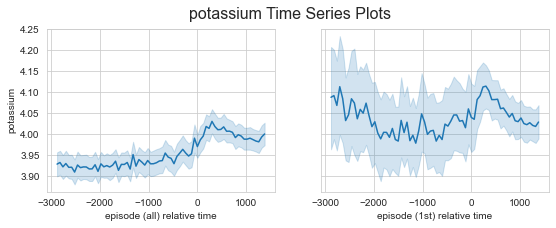

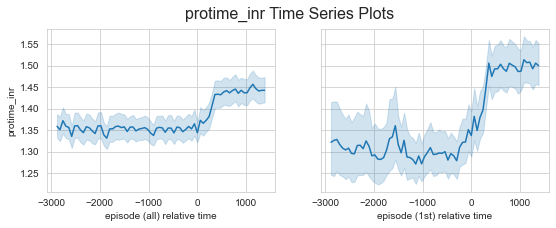

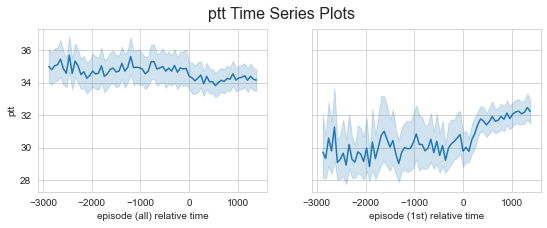

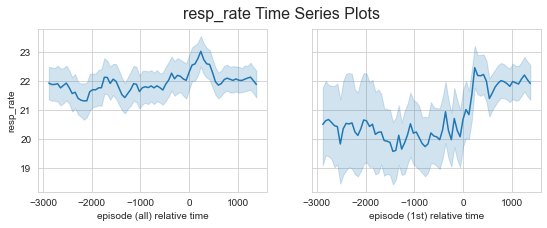

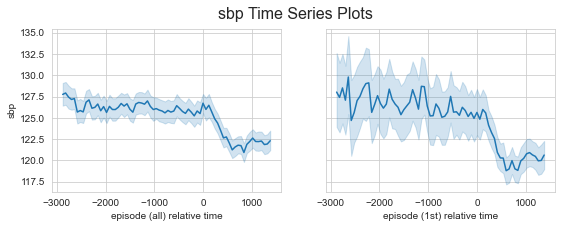

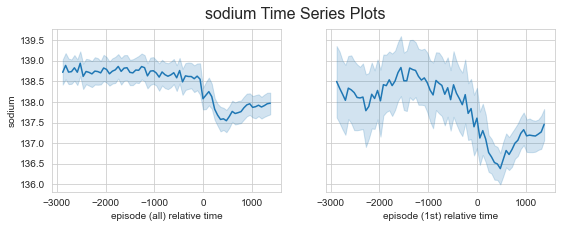

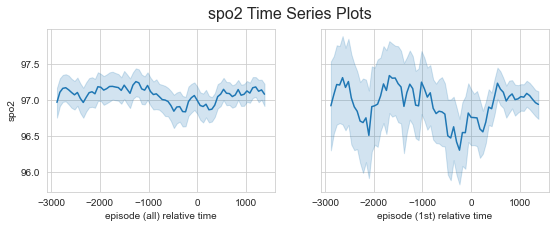

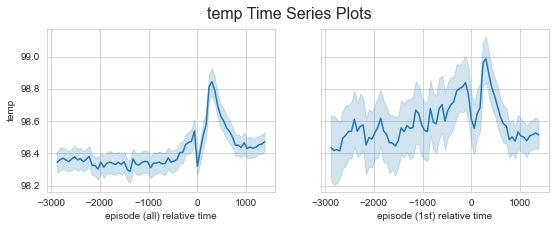

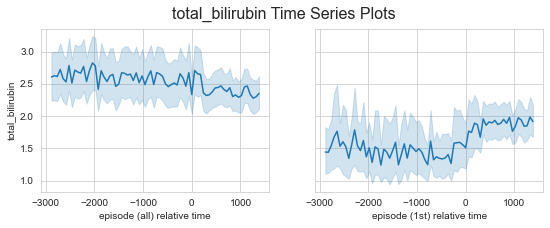

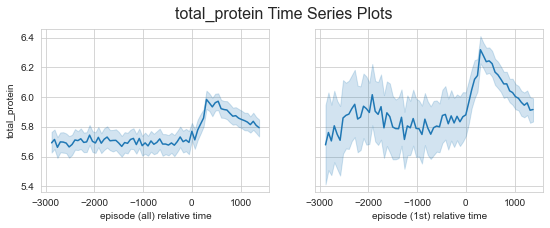

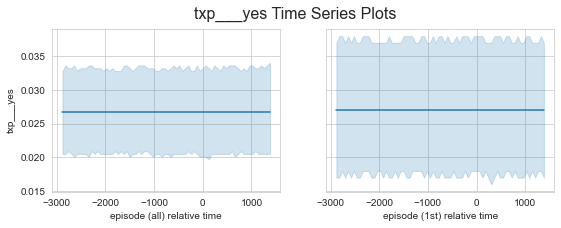

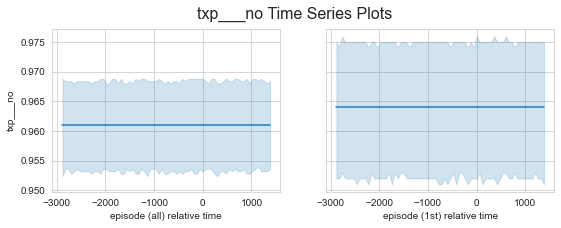

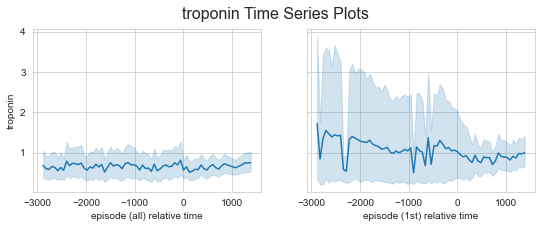

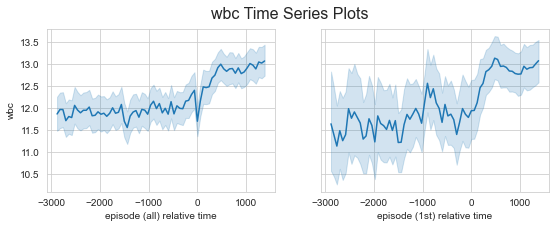

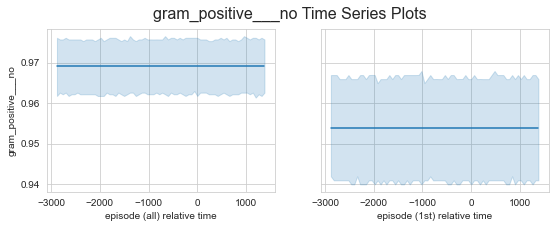

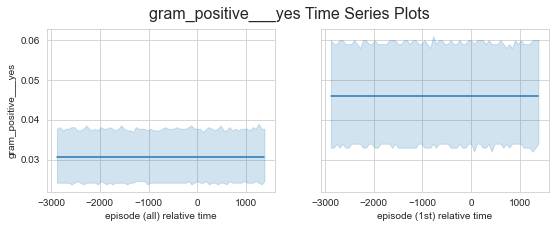

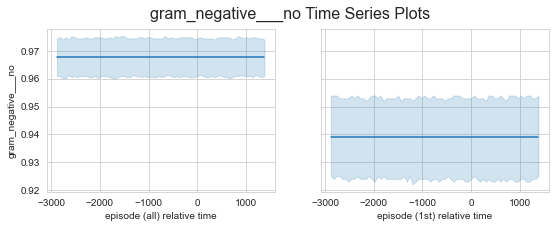

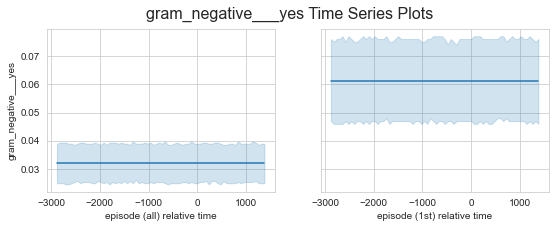

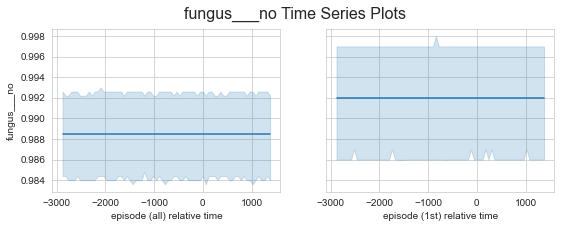

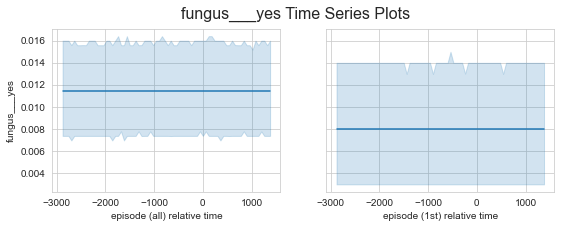

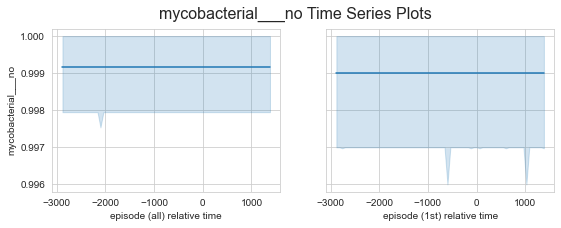

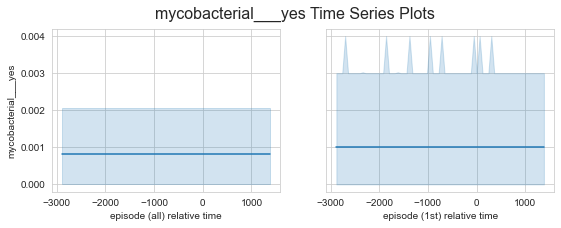

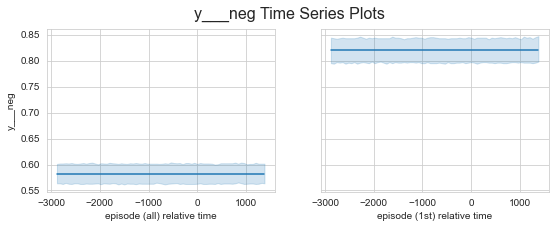

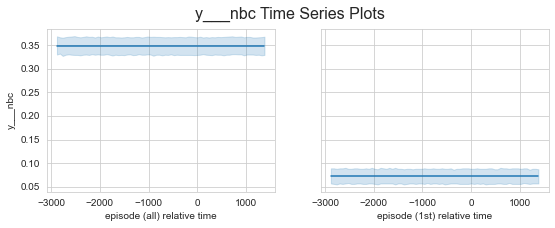

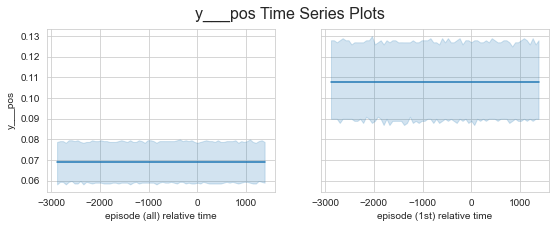

In [6]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('whitegrid')
def viz_episode_ts(df, fig_title=None):  
    
    if fig_title is None:
        fig_title = "Visualize Episode DataFrame"
 
    # if time series viz is possible
    if ("__ep_relative_time" in df.columns.tolist()) and ('__ep_order' in df.columns.tolist()):
        
        var_list = df.columns[~df.columns.isin(['__uid', '__time_bin', '__anchor', '__ep_relative_time', '__ep_order' ])]
        
        for var in var_list:
            fig, axs = plt.subplots(1, 2, figsize=(3*(2+1), 3*1), sharey='row') # width, height
            axs = axs.flatten()
            try:
                sns.lineplot(x='__ep_relative_time',y=str(var), data=df, ax=axs[0])
                axs[0].set_ylabel(str(var))
                axs[0].set_xlabel('episode (all) relative time')
            except:
                axs[0].set_xlabel("Error plot "+str(var)+" over episode relative time")
                pass
            
            try: 
                sns.lineplot(x='__ep_relative_time', y=str(var), data=df[df['__ep_order']==1], ax=axs[1])
                axs[1].set_xlabel('episode (1st) relative time')
            except:
                axs[1].set_xlabel("Error plot "+str(var))
                pass
            
            fig.suptitle(str(var)+" Time Series Plots",fontsize=16) 
            plt.show()
                
viz_episode_ts(all_df)

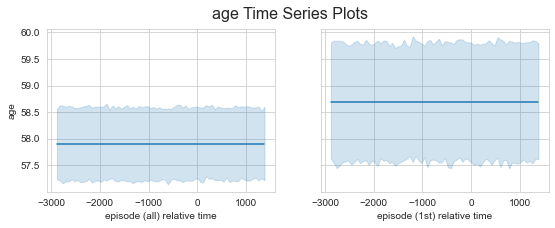

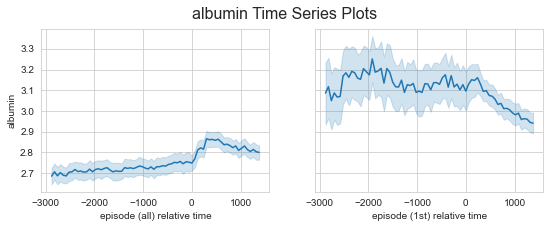

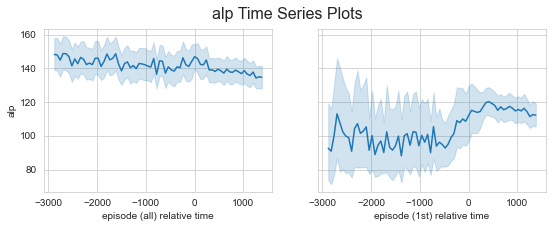

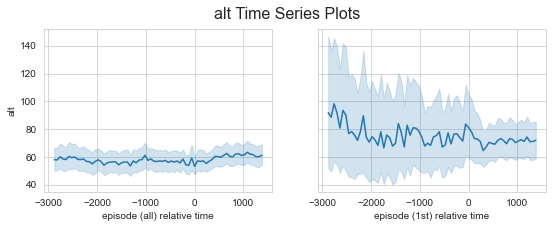

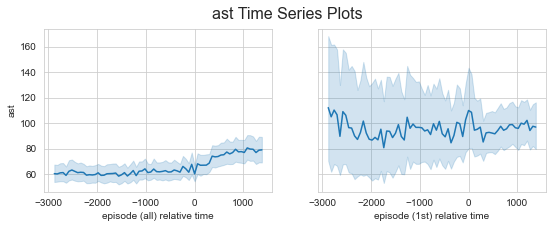

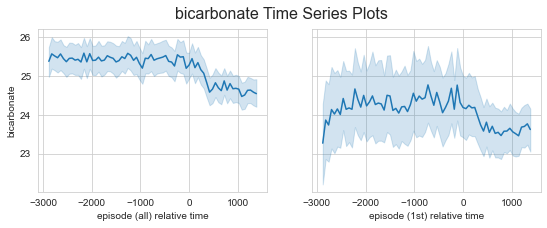

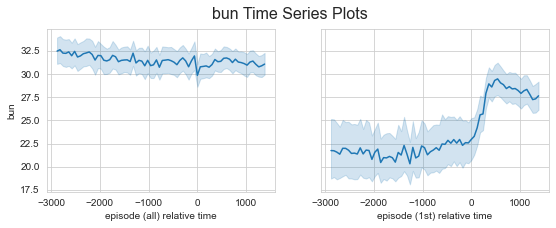

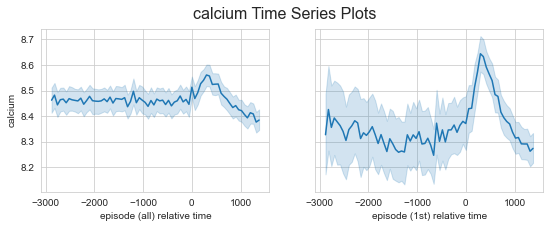

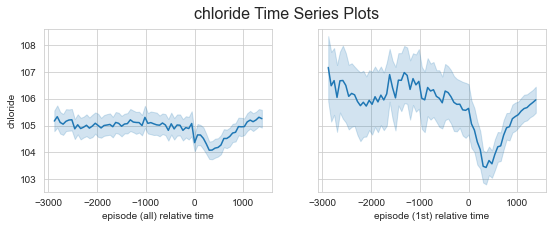

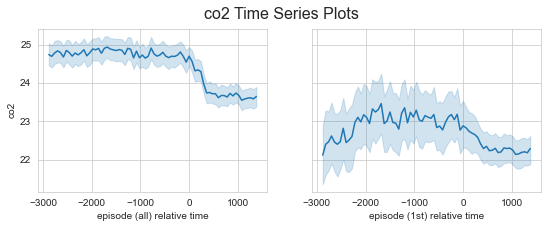

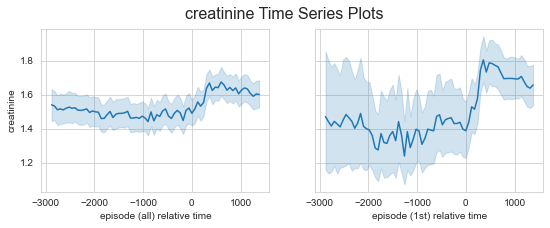

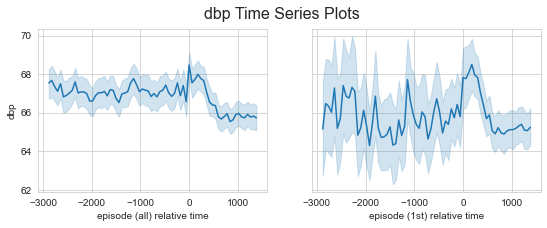

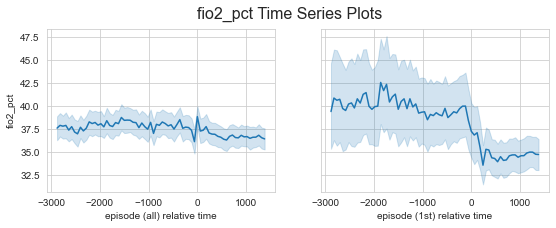

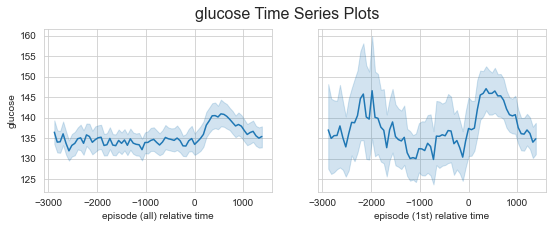

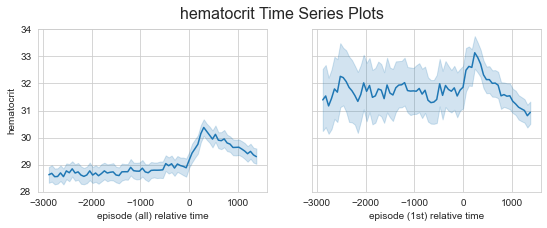

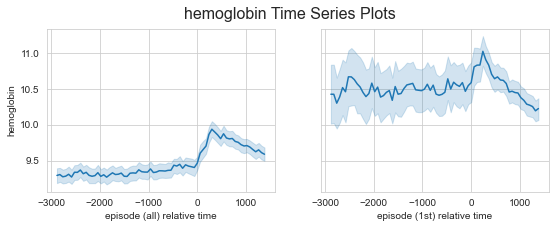

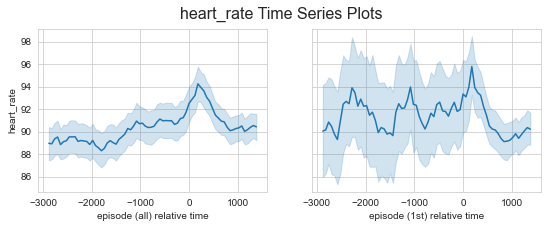

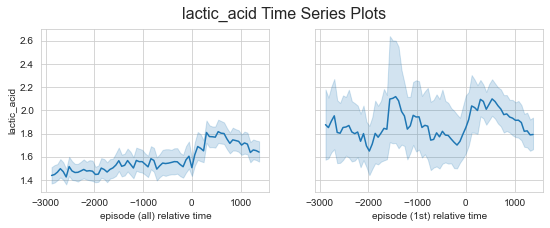

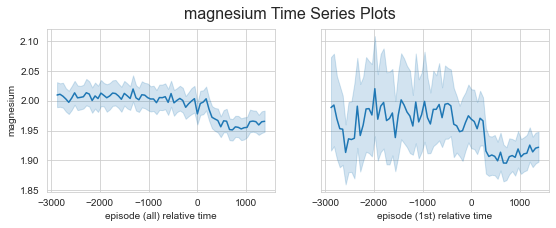

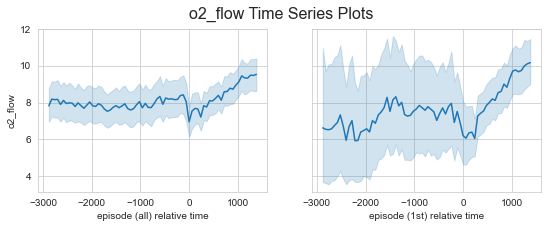

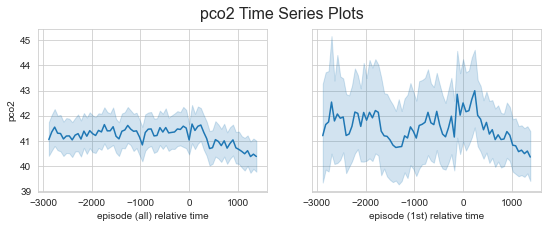

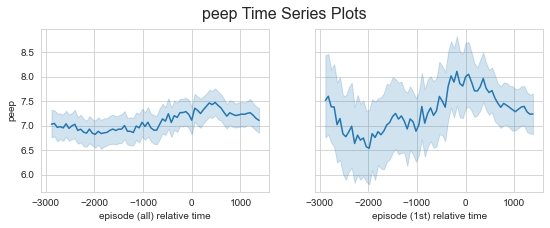

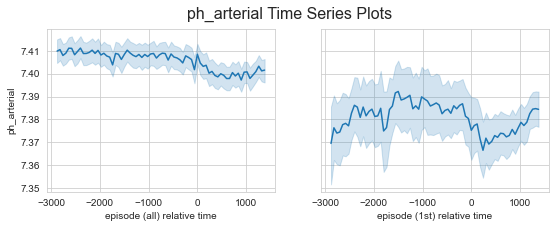

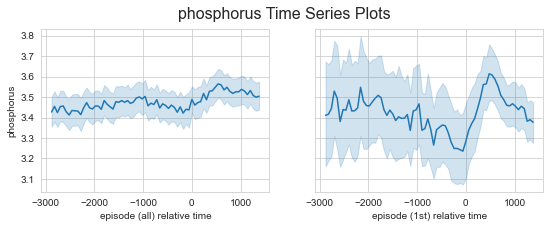

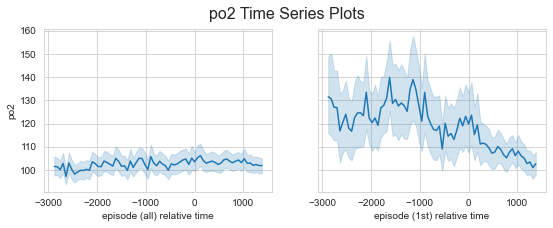

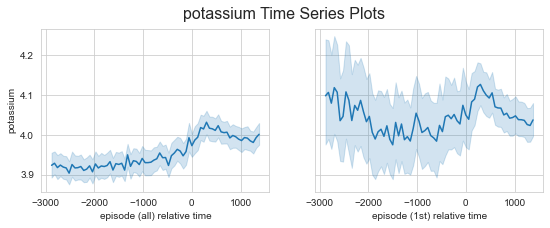

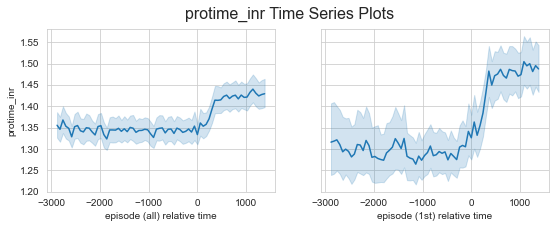

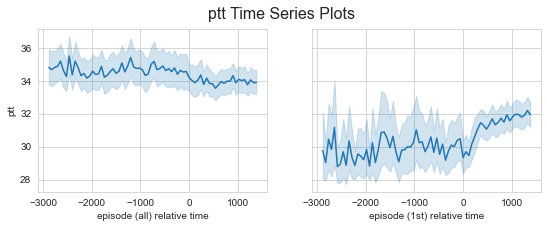

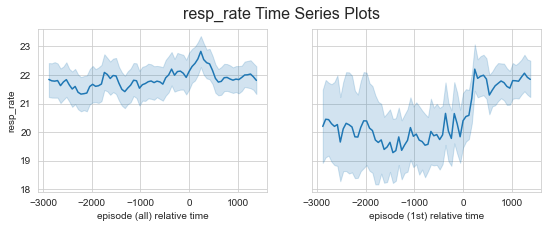

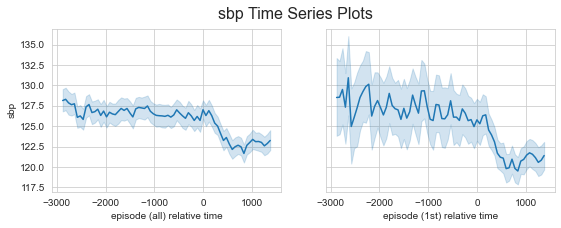

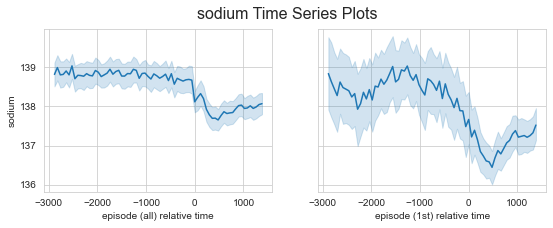

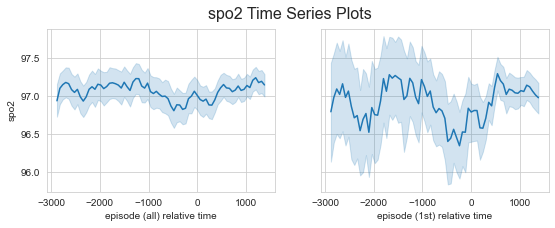

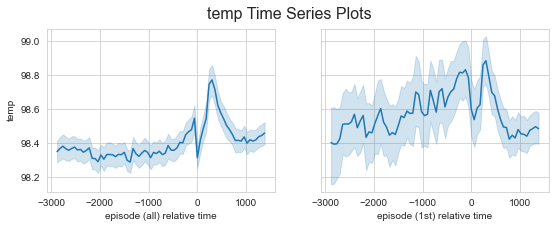

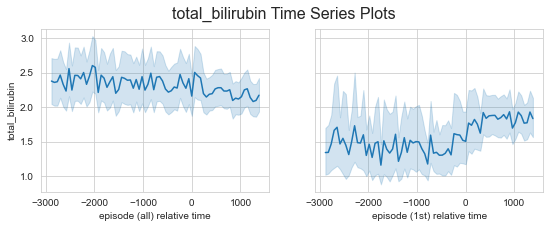

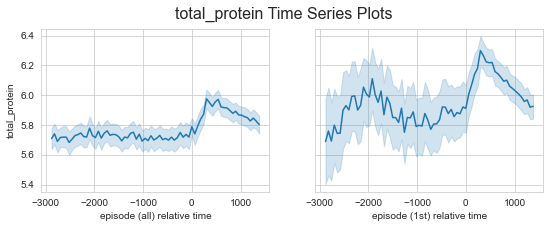

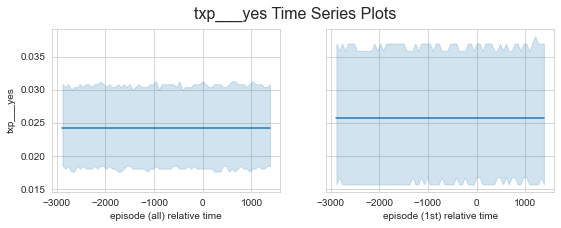

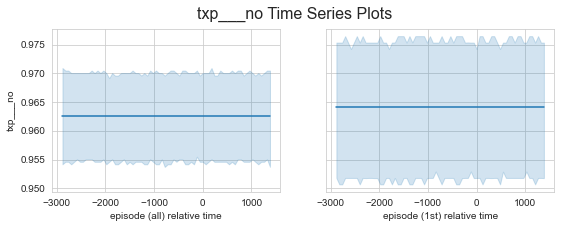

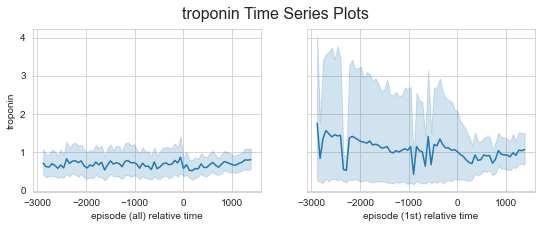

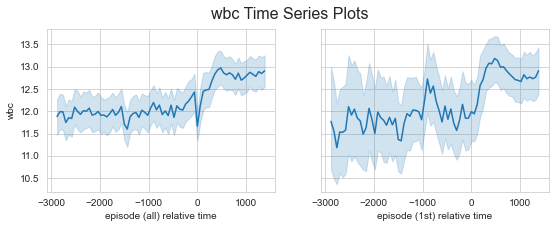

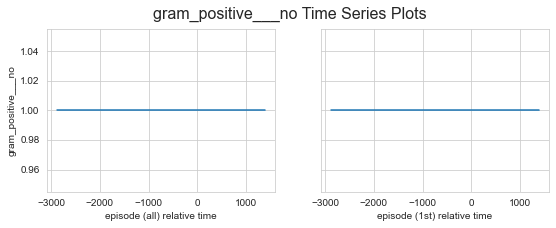

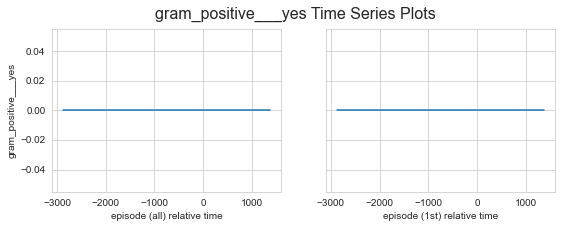

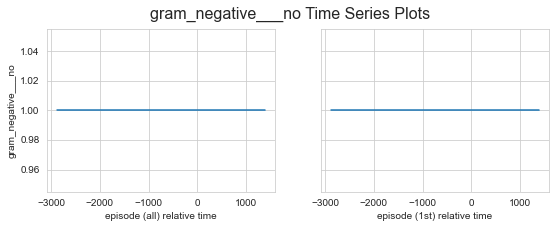

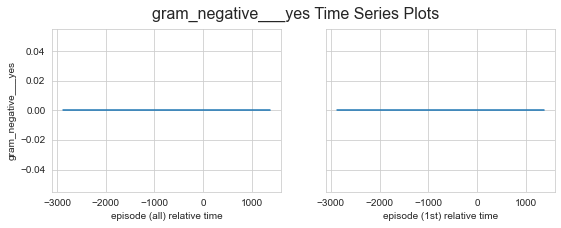

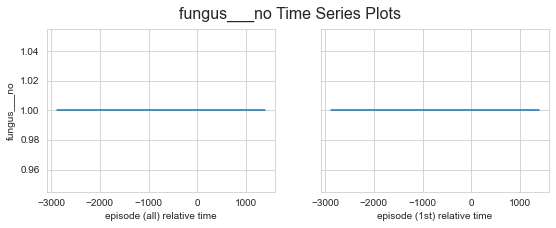

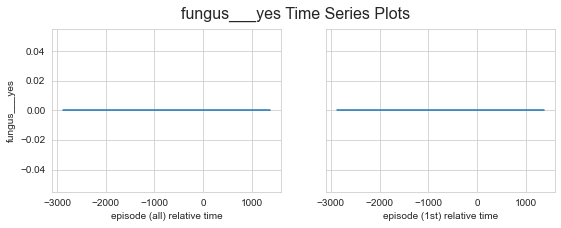

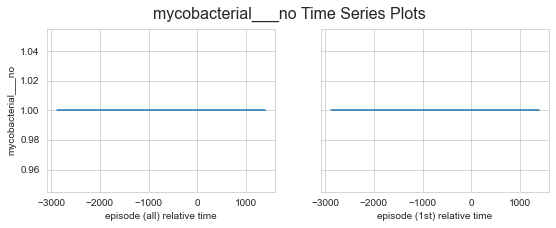

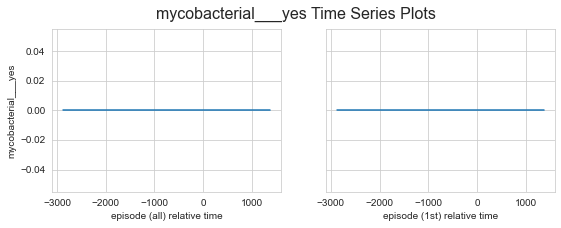

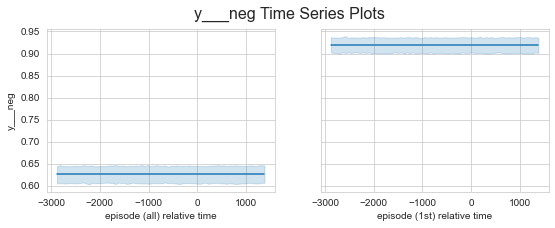

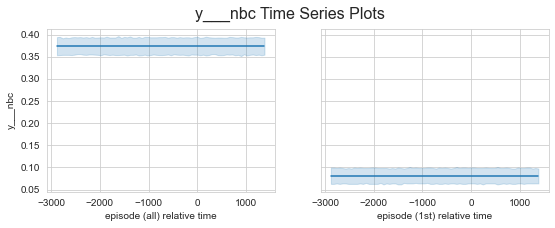

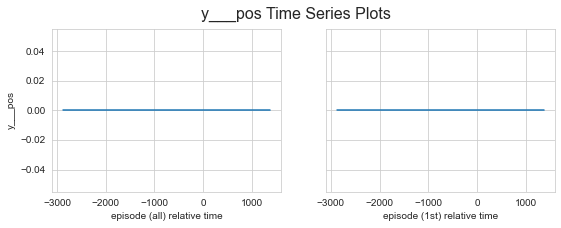

In [7]:
viz_episode_ts(all_df.loc[all_df.y___pos==0,:])

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [3]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'subject id',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'timeMinutes'],
  'label': 'Time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'episode anchor',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Blood culture result',
  'unique_per_sbj': False,
  'factor': {'levels': {'nbc': ['nan'],
    'neg': ['0', '0.0'],
    'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'nbc'}}},
 'age': {'input': True,
  'src_names': ['age', 'AGE'],
  'label': 'Age',
  'unique_per_sbj': True,
  'numeric': {'scaler': 'none',
   'unit': 'year',
   'cutoff': {'quantile_min': 0.0001,
    'quantile_max': 0.9999,
    'value_min': 0,
    'value_ma

In [4]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

Success! Engineer has updated attributes --- episode. 


In [5]:
print(bsi_stream.engineer.episode)

 
An episode is defined to 
--- use 2880 minute(s) long input variables 
--- predict 1440 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long


In [6]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 6000, # number of subjects / patients to sample from the pool 
                              replace=False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median',
                              sep="_")# imputation on response (no need in BSI project)
# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

Engineer is sampling without replacement --- 
5472---out of---5472---subjects are sampled from csv pool of size---31565
-- __time fixed
-- __anchor fixed
-- y fixed
--- fix variable dtype for age --- failed.
--- fix upper boundary for age --- failed.
--- fix lower boundary for age --- failed.
-- age fixed
--- fix upper boundary for albumin by 5.0
--- fix lower boundary for albumin by 1.2
-- albumin fixed
--- fix upper boundary for alp by 800.0
--- fix lower boundary for alp by 18.921
-- alp fixed
--- fix upper boundary for alt by 1085.0
--- fix lower boundary for alt by 6.0
-- alt fixed
--- fix upper boundary for ast by 1300.0
--- fix lower boundary for ast by 8.0
-- ast fixed
--- fix upper boundary for bicarbonate by 60.0
--- fix lower boundary for bicarbonate by 5.8252
-- bicarbonate fixed
--- fix upper boundary for bun by 150.0
--- fix lower boundary for bun by 2.0
-- bun fixed
--- fix upper boundary for calcium by 13.6
--- fix lower boundary for calcium by 5.3
-- calcium fixed
--- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.354167
y___nbc    0.625000
y___pos    0.020833
dtype: float64
--- prepare episodes for uvanew_1259001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.367347
y___nbc    0.612245
y___pos    0.020408
dtype: float64
--- prepare episodes for uvanew_1214001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.36
y___nbc    0.62
y___pos    0.02
dtype: float64
--- prepare episodes for uvanew_2588001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.339623
y___nbc    0.622642
y___pos    0.037736
dtype: float64
--- prepare episodes for uvanew_549001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.339286
y___nbc    0.625000
y___pos    0.035714
dtype: float64
--- prepare episodes for uvanew_1054001621
Success! Output/responce variable mean in current sample space  --- 
y___neg  

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.408
y___nbc    0.528
y___pos    0.064
dtype: float64
--- prepare episodes for uvanew_3954001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.404762
y___nbc    0.531746
y___pos    0.063492
dtype: float64
--- prepare episodes for uvanew_513001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.40625
y___nbc    0.53125
y___pos    0.06250
dtype: float64
--- prepare episodes for uvanew_5442001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.410853
y___nbc    0.527132
y___pos    0.062016
dtype: float64
--- prepare episodes for uvanew_5110001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415385
y___nbc    0.523077
y___pos    0.061538
dtype: float64
--- prepare episodes for uvanew_829001621
Success! Output/responce variable mean in current sample space  --- 
y___neg   

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.465608
y___nbc    0.465608
y___pos    0.068783
dtype: float64
--- prepare episodes for uvanew_4552001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.460733
y___nbc    0.465969
y___pos    0.073298
dtype: float64
--- prepare episodes for uvanew_380001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.461140
y___nbc    0.466321
y___pos    0.072539
dtype: float64
--- prepare episodes for uvanew_4836001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.463918
y___nbc    0.463918
y___pos    0.072165
dtype: float64
--- prepare episodes for uvanew_2871001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.461538
y___nbc    0.466667
y___pos    0.071795
dtype: float64
--- prepare episodes for uvanew_3785001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.459364
y___nbc    0.477032
y___pos    0.063604
dtype: float64
--- prepare episodes for uvanew_1311001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.461268
y___nbc    0.475352
y___pos    0.063380
dtype: float64
--- prepare episodes for uvanew_1271001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.459649
y___nbc    0.477193
y___pos    0.063158
dtype: float64
--- prepare episodes for uvanew_2709001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.459930
y___nbc    0.477352
y___pos    0.062718
dtype: float64
--- prepare episodes for uvanew_393001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.460208
y___nbc    0.477509
y___pos    0.062284
dtype: float64
--- prepare episodes for uvanew_2483001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.446927
y___nbc    0.486034
y___pos    0.067039
dtype: float64
--- prepare episodes for uvanew_2231001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.448468
y___nbc    0.484680
y___pos    0.066852
dtype: float64
--- prepare episodes for uvanew_5287001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.450000
y___nbc    0.483333
y___pos    0.066667
dtype: float64
--- prepare episodes for uvanew_3408001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.445055
y___nbc    0.486264
y___pos    0.068681
dtype: float64
--- prepare episodes for uvanew_4778001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.446575
y___nbc    0.484932
y___pos    0.068493
dtype: float64
--- prepare episodes for uvanew_3425001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.446262
y___nbc    0.485981
y___pos    0.067757
dtype: float64
--- prepare episodes for uvanew_5114001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.447552
y___nbc    0.484848
y___pos    0.067599
dtype: float64
--- prepare episodes for uvanew_4847001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.449074
y___nbc    0.481481
y___pos    0.069444
dtype: float64
--- prepare episodes for uvanew_4619001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.449309
y___nbc    0.481567
y___pos    0.069124
dtype: float64
--- prepare episodes for uvanew_2124001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.449541
y___nbc    0.481651
y___pos    0.068807
dtype: float64
--- prepare episodes for uvanew_1011001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436047
y___nbc    0.498062
y___pos    0.065891
dtype: float64
--- prepare episodes for uvanew_5203001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.435203
y___nbc    0.499033
y___pos    0.065764
dtype: float64
--- prepare episodes for uvanew_4314001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.434363
y___nbc    0.500000
y___pos    0.065637
dtype: float64
--- prepare episodes for uvanew_5221001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.435453
y___nbc    0.499037
y___pos    0.065511
dtype: float64
--- prepare episodes for uvanew_399001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436538
y___nbc    0.498077
y___pos    0.065385
dtype: float64
--- prepare episodes for uvanew_374001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.433673
y___nbc    0.493197
y___pos    0.073129
dtype: float64
--- prepare episodes for uvanew_1912001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.434635
y___nbc    0.492360
y___pos    0.073005
dtype: float64
--- prepare episodes for uvanew_4066001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.434856
y___nbc    0.492386
y___pos    0.072758
dtype: float64
--- prepare episodes for uvanew_1336001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.435811
y___nbc    0.491554
y___pos    0.072635
dtype: float64
--- prepare episodes for uvanew_903001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.434564
y___nbc    0.491611
y___pos    0.073826
dtype: float64
--- prepare episodes for uvanew_3233001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.444947
y___nbc    0.478130
y___pos    0.076923
dtype: float64
--- prepare episodes for uvanew_5327001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.445783
y___nbc    0.477410
y___pos    0.076807
dtype: float64
--- prepare episodes for uvanew_3888001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.445113
y___nbc    0.478195
y___pos    0.076692
dtype: float64
--- prepare episodes for uvanew_1307001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.445946
y___nbc    0.477477
y___pos    0.076577
dtype: float64
--- prepare episodes for uvanew_643001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.446777
y___nbc    0.476762
y___pos    0.076462
dtype: float64
--- prepare episodes for uvanew_3138001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.439456
y___nbc    0.485714
y___pos    0.074830
dtype: float64
--- prepare episodes for uvanew_4812001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.440217
y___nbc    0.485054
y___pos    0.074728
dtype: float64
--- prepare episodes for uvanew_23001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.440977
y___nbc    0.484396
y___pos    0.074627
dtype: float64
--- prepare episodes for uvanew_1652001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.441734
y___nbc    0.483740
y___pos    0.074526
dtype: float64
--- prepare episodes for uvanew_5231001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.441137
y___nbc    0.484438
y___pos    0.074425
dtype: float64
--- prepare episodes for uvanew_4340001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.448319
y___nbc    0.479452
y___pos    0.072229
dtype: float64
--- prepare episodes for uvanew_4825001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.447761
y___nbc    0.480100
y___pos    0.072139
dtype: float64
--- prepare episodes for uvanew_3984001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.446097
y___nbc    0.482032
y___pos    0.071871
dtype: float64
--- prepare episodes for uvanew_122001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.446782
y___nbc    0.481436
y___pos    0.071782
dtype: float64
--- prepare episodes for uvanew_1046001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.447466
y___nbc    0.480841
y___pos    0.071693
dtype: float64
--- prepare episodes for uvanew_3513001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.443311
y___nbc    0.484127
y___pos    0.072562
dtype: float64
--- prepare episodes for uvanew_144001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.442809
y___nbc    0.484711
y___pos    0.072480
dtype: float64
--- prepare episodes for uvanew_4874001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.443439
y___nbc    0.484163
y___pos    0.072398
dtype: float64
--- prepare episodes for uvanew_366001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.443567
y___nbc    0.484199
y___pos    0.072235
dtype: float64
--- prepare episodes for uvanew_59001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.444194
y___nbc    0.483653
y___pos    0.072153
dtype: float64
--- prepare episodes for uvanew_5305001621
Success! Output/responce variable mean in current sample space  --- 


y___neg    0.440501
y___nbc    0.484342
y___pos    0.075157
dtype: float64
--- prepare episodes for uvanew_4651001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.440042
y___nbc    0.484880
y___pos    0.075078
dtype: float64
--- prepare episodes for uvanew_3468001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.440625
y___nbc    0.484375
y___pos    0.075000
dtype: float64
--- prepare episodes for uvanew_3512001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.440748
y___nbc    0.484407
y___pos    0.074844
dtype: float64
--- prepare episodes for uvanew_1215001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.441329
y___nbc    0.483904
y___pos    0.074766
dtype: float64
--- prepare episodes for uvanew_3660001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.441909
y___nbc    0.483402
y___pos    0.074689
dtype

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.440777
y___nbc    0.485437
y___pos    0.073786
dtype: float64
--- prepare episodes for uvanew_1399001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.440891
y___nbc    0.485465
y___pos    0.073643
dtype: float64
--- prepare episodes for uvanew_4938001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.441433
y___nbc    0.484995
y___pos    0.073572
dtype: float64
--- prepare episodes for uvanew_5352001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.441006
y___nbc    0.485493
y___pos    0.073501
dtype: float64
--- prepare episodes for uvanew_1469001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.441546
y___nbc    0.485024
y___pos    0.073430
dtype: float64
--- prepare episodes for uvanew_1141001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.447368
y___nbc    0.481851
y___pos    0.070780
dtype: float64
--- prepare episodes for uvanew_4016001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.447059
y___nbc    0.481448
y___pos    0.071493
dtype: float64
--- prepare episodes for uvanew_4191001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.447559
y___nbc    0.481013
y___pos    0.071429
dtype: float64
--- prepare episodes for uvanew_85001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.448058
y___nbc    0.480578
y___pos    0.071364
dtype: float64
--- prepare episodes for uvanew_457001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.448151
y___nbc    0.480613
y___pos    0.071235
dtype: float64
--- prepare episodes for uvanew_1732001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.452442
y___nbc    0.475578
y___pos    0.071979
dtype: float64
--- prepare episodes for uvanew_2030001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.452911
y___nbc    0.475171
y___pos    0.071918
dtype: float64
--- prepare episodes for uvanew_2462001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.452524
y___nbc    0.475620
y___pos    0.071856
dtype: float64
--- prepare episodes for uvanew_1350001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.452605
y___nbc    0.475662
y___pos    0.071734
dtype: float64
--- prepare episodes for uvanew_3016001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.452766
y___nbc    0.474043
y___pos    0.073191
dtype: float64
--- prepare episodes for uvanew_1837001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.448387
y___nbc    0.479032
y___pos    0.072581
dtype: float64
--- prepare episodes for uvanew_31001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436962
y___nbc    0.492561
y___pos    0.070478
dtype: float64
--- prepare episodes for uvanew_3992001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.437402
y___nbc    0.492175
y___pos    0.070423
dtype: float64
--- prepare episodes for uvanew_527001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.437842
y___nbc    0.491790
y___pos    0.070367
dtype: float64
--- prepare episodes for uvanew_2777001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.437500
y___nbc    0.492188
y___pos    0.070312
dtype: float64
--- prepare episodes for uvanew_2553001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436714
y___nbc    0.493708
y___pos    0.069578
dtype: float64
--- prepare episodes for uvanew_2208001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436807
y___nbc    0.493718
y___pos    0.069475
dtype: float64
--- prepare episodes for uvanew_5034001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436484
y___nbc    0.494092
y___pos    0.069424
dtype: float64
--- prepare episodes for uvanew_4031001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436900
y___nbc    0.493727
y___pos    0.069373
dtype: float64
--- prepare episodes for uvanew_2299001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.436672
y___nbc    0.493373
y___pos    0.069956
dtype: float64
--- prepare episodes for uvanew_3777001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.439298
y___nbc    0.491930
y___pos    0.068772
dtype: float64
--- prepare episodes for uvanew_1873001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.438990
y___nbc    0.492286
y___pos    0.068724
dtype: float64
--- prepare episodes for uvanew_580001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.438683
y___nbc    0.492642
y___pos    0.068676
dtype: float64
--- prepare episodes for uvanew_5108001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.439076
y___nbc    0.492297
y___pos    0.068627
dtype: float64
--- prepare episodes for uvanew_2984001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.439468
y___nbc    0.491952
y___pos    0.068579
dtype: float64
--- prepare episodes for uvanew_991001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.432220
y___nbc    0.501637
y___pos    0.066143
dtype: float64
--- prepare episodes for uvanew_4228001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.431937
y___nbc    0.501963
y___pos    0.066099
dtype: float64
--- prepare episodes for uvanew_2569001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.432309
y___nbc    0.501635
y___pos    0.066056
dtype: float64
--- prepare episodes for uvanew_135001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.431744
y___nbc    0.502286
y___pos    0.065970
dtype: float64
--- prepare episodes for uvanew_3073001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.432115
y___nbc    0.501958
y___pos    0.065927
dtype: float64
--- prepare episodes for uvanew_3599001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.429731
y___nbc    0.502811
y___pos    0.067458
dtype: float64
--- prepare episodes for uvanew_5168001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.429463
y___nbc    0.503121
y___pos    0.067416
dtype: float64
--- prepare episodes for uvanew_1203001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.429551
y___nbc    0.503117
y___pos    0.067332
dtype: float64
--- prepare episodes for uvanew_3644001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.429907
y___nbc    0.502804
y___pos    0.067290
dtype: float64
--- prepare episodes for uvanew_3403001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.430262
y___nbc    0.502491
y___pos    0.067248
dtype: float64
--- prepare episodes for uvanew_4979001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427893
y___nbc    0.504451
y___pos    0.067656
dtype: float64
--- prepare episodes for uvanew_1954001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428233
y___nbc    0.504152
y___pos    0.067616
dtype: float64
--- prepare episodes for uvanew_3364001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428571
y___nbc    0.503853
y___pos    0.067576
dtype: float64
--- prepare episodes for uvanew_5267001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428910
y___nbc    0.503555
y___pos    0.067536
dtype: float64
--- prepare episodes for uvanew_632001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428402
y___nbc    0.504142
y___pos    0.067456
dtype: float64
--- prepare episodes for uvanew_2620001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.429304
y___nbc    0.502851
y___pos    0.067845
dtype: float64
--- prepare episodes for uvanew_679001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.429630
y___nbc    0.502564
y___pos    0.067806
dtype: float64
--- prepare episodes for uvanew_3228001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.429954
y___nbc    0.502278
y___pos    0.067768
dtype: float64
--- prepare episodes for uvanew_4850001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.430279
y___nbc    0.501992
y___pos    0.067729
dtype: float64
--- prepare episodes for uvanew_4474001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.430034
y___nbc    0.502275
y___pos    0.067691
dtype: float64
--- prepare episodes for uvanew_5319001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428883
y___nbc    0.502452
y___pos    0.068665
dtype: float64
--- prepare episodes for uvanew_4454001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428649
y___nbc    0.502723
y___pos    0.068627
dtype: float64
--- prepare episodes for uvanew_1425001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428416
y___nbc    0.502994
y___pos    0.068590
dtype: float64
--- prepare episodes for uvanew_1296001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428183
y___nbc    0.503264
y___pos    0.068553
dtype: float64
--- prepare episodes for uvanew_5240001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428494
y___nbc    0.502991
y___pos    0.068515
dtype: float64
--- prepare episodes for uvanew_951001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427532
y___nbc    0.503896
y___pos    0.068571
dtype: float64
--- prepare episodes for uvanew_3750001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427310
y___nbc    0.503634
y___pos    0.069055
dtype: float64
--- prepare episodes for uvanew_5167001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427164
y___nbc    0.503370
y___pos    0.069466
dtype: float64
--- prepare episodes for uvanew_2952001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427240
y___nbc    0.502848
y___pos    0.069912
dtype: float64
--- prepare episodes for uvanew_3271001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426798
y___nbc    0.503363
y___pos    0.069840
dtype: float64
--- prepare episodes for uvanew_5067001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426353
y___nbc    0.504008
y___pos    0.069639
dtype: float64
--- prepare episodes for uvanew_2691001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426426
y___nbc    0.504004
y___pos    0.069570
dtype: float64
--- prepare episodes for uvanew_34001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426713
y___nbc    0.503752
y___pos    0.069535
dtype: float64
--- prepare episodes for uvanew_1727001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.4270
y___nbc    0.5035
y___pos    0.0695
dtype: float64
--- prepare episodes for uvanew_3899001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426787
y___nbc    0.503748
y___pos    0.069465
dtype: float64
--- prepare episodes for uvanew_3776001621
Success! Output/responce variable mean in current sample space  --- 
y___

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.42500
y___nbc    0.50625
y___pos    0.06875
dtype: float64
--- prepare episodes for uvanew_4909001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.425276
y___nbc    0.506007
y___pos    0.068717
dtype: float64
--- prepare episodes for uvanew_5129001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.425072
y___nbc    0.505764
y___pos    0.069164
dtype: float64
--- prepare episodes for uvanew_235001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.425348
y___nbc    0.505521
y___pos    0.069131
dtype: float64
--- prepare episodes for uvanew_4399001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.425624
y___nbc    0.505278
y___pos    0.069098
dtype: float64
--- prepare episodes for uvanew_1871001621
Success! Output/responce variable mean in current sample space  --- 


Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426784
y___nbc    0.504171
y___pos    0.069045
dtype: float64
--- prepare episodes for uvanew_3360001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427050
y___nbc    0.503937
y___pos    0.069013
dtype: float64
--- prepare episodes for uvanew_4301001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426852
y___nbc    0.503704
y___pos    0.069444
dtype: float64
--- prepare episodes for uvanew_4919001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427117
y___nbc    0.503471
y___pos    0.069412
dtype: float64
--- prepare episodes for uvanew_4269001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.42692
y___nbc    0.50370
y___pos    0.06938
dtype: float64
--- prepare episodes for uvanew_3911001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426649
y___nbc    0.504711
y___pos    0.068641
dtype: float64
--- prepare episodes for uvanew_3461001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426523
y___nbc    0.504928
y___pos    0.068548
dtype: float64
--- prepare episodes for uvanew_16001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426332
y___nbc    0.505150
y___pos    0.068518
dtype: float64
--- prepare episodes for uvanew_478001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426589
y___nbc    0.504924
y___pos    0.068487
dtype: float64
--- prepare episodes for uvanew_3669001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426846
y___nbc    0.504698
y___pos    0.068456
dtype: float64
--- prepare episodes for uvanew_1395001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428012
y___nbc    0.501957
y___pos    0.070030
dtype: float64
--- prepare episodes for uvanew_2865001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428075
y___nbc    0.501521
y___pos    0.070404
dtype: float64
--- prepare episodes for uvanew_965001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.427889
y___nbc    0.501738
y___pos    0.070374
dtype: float64
--- prepare episodes for uvanew_4403001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428137
y___nbc    0.501520
y___pos    0.070343
dtype: float64
--- prepare episodes for uvanew_2572001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.428385
y___nbc    0.501302
y___pos    0.070312
dtype: float64
--- prepare episodes for uvanew_1491001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426538
y___nbc    0.503139
y___pos    0.070322
dtype: float64
--- prepare episodes for uvanew_210001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426127
y___nbc    0.503756
y___pos    0.070117
dtype: float64
--- prepare episodes for uvanew_2902001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426366
y___nbc    0.503546
y___pos    0.070088
dtype: float64
--- prepare episodes for uvanew_5157001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426606
y___nbc    0.503336
y___pos    0.070058
dtype: float64
--- prepare episodes for uvanew_1090001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.426845
y___nbc    0.503126
y___pos    0.070029
dtype: float64
--- prepare episodes for uvanew_1798001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.425566
y___nbc    0.505259
y___pos    0.069175
dtype: float64
--- prepare episodes for uvanew_618001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.425111
y___nbc    0.505854
y___pos    0.069035
dtype: float64
--- prepare episodes for uvanew_3180001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.425000
y___nbc    0.505645
y___pos    0.069355
dtype: float64
--- prepare episodes for uvanew_1183001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.424547
y___nbc    0.506237
y___pos    0.069215
dtype: float64
--- prepare episodes for uvanew_1518001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.424377
y___nbc    0.506436
y___pos    0.069187
dtype: float64
--- prepare episodes for uvanew_3357001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423167
y___nbc    0.508970
y___pos    0.067863
dtype: float64
--- prepare episodes for uvanew_5133001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423392
y___nbc    0.508772
y___pos    0.067836
dtype: float64
--- prepare episodes for uvanew_942001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422793
y___nbc    0.509529
y___pos    0.067678
dtype: float64
--- prepare episodes for uvanew_687001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422628
y___nbc    0.509720
y___pos    0.067652
dtype: float64
--- prepare episodes for uvanew_4922001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422853
y___nbc    0.509522
y___pos    0.067625
dtype: float64
--- prepare episodes for uvanew_4130001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.424300
y___nbc    0.508327
y___pos    0.067373
dtype: float64
--- prepare episodes for uvanew_2377001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423819
y___nbc    0.508885
y___pos    0.067297
dtype: float64
--- prepare episodes for uvanew_463001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423876
y___nbc    0.508878
y___pos    0.067246
dtype: float64
--- prepare episodes for uvanew_2999001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423774
y___nbc    0.508679
y___pos    0.067547
dtype: float64
--- prepare episodes for uvanew_4994001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423991
y___nbc    0.508487
y___pos    0.067522
dtype: float64
--- prepare episodes for uvanew_510001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423119
y___nbc    0.510092
y___pos    0.066789
dtype: float64
--- prepare episodes for uvanew_3436001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422499
y___nbc    0.510810
y___pos    0.066691
dtype: float64
--- prepare episodes for uvanew_928001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422344
y___nbc    0.510989
y___pos    0.066667
dtype: float64
--- prepare episodes for uvanew_4802001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422556
y___nbc    0.510802
y___pos    0.066642
dtype: float64
--- prepare episodes for uvanew_3949001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422767
y___nbc    0.510615
y___pos    0.066618
dtype: float64
--- prepare episodes for uvanew_2536001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421429
y___nbc    0.512143
y___pos    0.066429
dtype: float64
--- prepare episodes for uvanew_1600001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421128
y___nbc    0.512491
y___pos    0.066381
dtype: float64
--- prepare episodes for uvanew_2546001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421541
y___nbc    0.512126
y___pos    0.066334
dtype: float64
--- prepare episodes for uvanew_2980001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421390
y___nbc    0.512299
y___pos    0.066310
dtype: float64
--- prepare episodes for uvanew_1995001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421597
y___nbc    0.512117
y___pos    0.066287
dtype: float64
--- prepare episodes for uvanew_3480001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423264
y___nbc    0.508681
y___pos    0.068056
dtype: float64
--- prepare episodes for uvanew_2141001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423664
y___nbc    0.508328
y___pos    0.068008
dtype: float64
--- prepare episodes for uvanew_2322001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423864
y___nbc    0.508151
y___pos    0.067985
dtype: float64
--- prepare episodes for uvanew_71001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423717
y___nbc    0.508322
y___pos    0.067961
dtype: float64
--- prepare episodes for uvanew_1922001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423570
y___nbc    0.508492
y___pos    0.067938
dtype: float64
--- prepare episodes for uvanew_5024001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422207
y___nbc    0.508944
y___pos    0.068849
dtype: float64
--- prepare episodes for uvanew_3177001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422402
y___nbc    0.508772
y___pos    0.068826
dtype: float64
--- prepare episodes for uvanew_4382001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422260
y___nbc    0.508938
y___pos    0.068803
dtype: float64
--- prepare episodes for uvanew_1672001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422170
y___nbc    0.509097
y___pos    0.068733
dtype: float64
--- prepare episodes for uvanew_2988001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422222
y___nbc    0.509091
y___pos    0.068687
dtype: float64
--- prepare episodes for uvanew_1287001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421105
y___nbc    0.511506
y___pos    0.067390
dtype: float64
--- prepare episodes for uvanew_888001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421295
y___nbc    0.511337
y___pos    0.067368
dtype: float64
--- prepare episodes for uvanew_3393001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421208
y___nbc    0.511490
y___pos    0.067301
dtype: float64
--- prepare episodes for uvanew_1377001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421070
y___nbc    0.511323
y___pos    0.067607
dtype: float64
--- prepare episodes for uvanew_2296001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421260
y___nbc    0.511155
y___pos    0.067585
dtype: float64
--- prepare episodes for uvanew_2444001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419686
y___nbc    0.512023
y___pos    0.068291
dtype: float64
--- prepare episodes for uvanew_3694001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419551
y___nbc    0.512179
y___pos    0.068269
dtype: float64
--- prepare episodes for uvanew_4948001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419737
y___nbc    0.512015
y___pos    0.068247
dtype: float64
--- prepare episodes for uvanew_3066001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419923
y___nbc    0.511851
y___pos    0.068225
dtype: float64
--- prepare episodes for uvanew_5308001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.41984
y___nbc    0.51168
y___pos    0.06848
dtype: float64
--- prepare episodes for uvanew_3246001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420163
y___nbc    0.512523
y___pos    0.067314
dtype: float64
--- prepare episodes for uvanew_637001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420031
y___nbc    0.512676
y___pos    0.067293
dtype: float64
--- prepare episodes for uvanew_1146001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420213
y___nbc    0.512516
y___pos    0.067272
dtype: float64
--- prepare episodes for uvanew_197001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420263
y___nbc    0.512508
y___pos    0.067230
dtype: float64
--- prepare episodes for uvanew_1340001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420444
y___nbc    0.512348
y___pos    0.067209
dtype: float64
--- prepare episodes for uvanew_1933001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421391
y___nbc    0.511799
y___pos    0.066810
dtype: float64
--- prepare episodes for uvanew_2177001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421262
y___nbc    0.511949
y___pos    0.066789
dtype: float64
--- prepare episodes for uvanew_95001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421004
y___nbc    0.512247
y___pos    0.066748
dtype: float64
--- prepare episodes for uvanew_690001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421053
y___nbc    0.512240
y___pos    0.066707
dtype: float64
--- prepare episodes for uvanew_5325001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421230
y___nbc    0.512083
y___pos    0.066687
dtype: float64
--- prepare episodes for uvanew_1060001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422569
y___nbc    0.510504
y___pos    0.066927
dtype: float64
--- prepare episodes for uvanew_4309001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422442
y___nbc    0.510651
y___pos    0.066907
dtype: float64
--- prepare episodes for uvanew_3043001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422489
y___nbc    0.510345
y___pos    0.067166
dtype: float64
--- prepare episodes for uvanew_1186001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422535
y___nbc    0.510339
y___pos    0.067126
dtype: float64
--- prepare episodes for uvanew_4169001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422708
y___nbc    0.510186
y___pos    0.067106
dtype: float64
--- prepare episodes for uvanew_3649001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419825
y___nbc    0.513411
y___pos    0.066764
dtype: float64
--- prepare episodes for uvanew_3821001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419703
y___nbc    0.513553
y___pos    0.066744
dtype: float64
--- prepare episodes for uvanew_405001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419872
y___nbc    0.513403
y___pos    0.066725
dtype: float64
--- prepare episodes for uvanew_3639001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419918
y___nbc    0.513395
y___pos    0.066686
dtype: float64
--- prepare episodes for uvanew_5147001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420087
y___nbc    0.513246
y___pos    0.066667
dtype: float64
--- prepare episodes for uvanew_2489001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420063
y___nbc    0.514107
y___pos    0.065831
dtype: float64
--- prepare episodes for uvanew_600001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420228
y___nbc    0.513960
y___pos    0.065812
dtype: float64
--- prepare episodes for uvanew_5260001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420273
y___nbc    0.513952
y___pos    0.065774
dtype: float64
--- prepare episodes for uvanew_4893001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420438
y___nbc    0.513806
y___pos    0.065756
dtype: float64
--- prepare episodes for uvanew_2273001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420603
y___nbc    0.513660
y___pos    0.065737
dtype: float64
--- prepare episodes for uvanew_2515001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421465
y___nbc    0.513415
y___pos    0.065120
dtype: float64
--- prepare episodes for uvanew_3865001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421155
y___nbc    0.513257
y___pos    0.065587
dtype: float64
--- prepare episodes for uvanew_1106001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421317
y___nbc    0.513114
y___pos    0.065569
dtype: float64
--- prepare episodes for uvanew_3213001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421478
y___nbc    0.512971
y___pos    0.065551
dtype: float64
--- prepare episodes for uvanew_4271001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421405
y___nbc    0.512821
y___pos    0.065775
dtype: float64
--- prepare episodes for uvanew_263001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420765
y___nbc    0.512842
y___pos    0.066393
dtype: float64
--- prepare episodes for uvanew_1010001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420808
y___nbc    0.512835
y___pos    0.066357
dtype: float64
--- prepare episodes for uvanew_3299001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420966
y___nbc    0.512695
y___pos    0.066339
dtype: float64
--- prepare episodes for uvanew_4476001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421124
y___nbc    0.512555
y___pos    0.066321
dtype: float64
--- prepare episodes for uvanew_278001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421010
y___nbc    0.512688
y___pos    0.066303
dtype: float64
--- prepare episodes for uvanew_5181001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422181
y___nbc    0.511385
y___pos    0.066435
dtype: float64
--- prepare episodes for uvanew_4208001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422335
y___nbc    0.511248
y___pos    0.066417
dtype: float64
--- prepare episodes for uvanew_2327001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422377
y___nbc    0.511242
y___pos    0.066381
dtype: float64
--- prepare episodes for uvanew_2095001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422151
y___nbc    0.511503
y___pos    0.066346
dtype: float64
--- prepare episodes for uvanew_2032001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422305
y___nbc    0.511367
y___pos    0.066328
dtype: float64
--- prepare episodes for uvanew_558001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421994
y___nbc    0.511707
y___pos    0.066298
dtype: float64
--- prepare episodes for uvanew_5264001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421924
y___nbc    0.511567
y___pos    0.066509
dtype: float64
--- prepare episodes for uvanew_4161001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422076
y___nbc    0.511432
y___pos    0.066491
dtype: float64
--- prepare episodes for uvanew_1560001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422117
y___nbc    0.511426
y___pos    0.066457
dtype: float64
--- prepare episodes for uvanew_3086001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422047
y___nbc    0.511549
y___pos    0.066404
dtype: float64
--- prepare episodes for uvanew_5291001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421283
y___nbc    0.512239
y___pos    0.066478
dtype: float64
--- prepare episodes for uvanew_3539001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421432
y___nbc    0.512107
y___pos    0.066461
dtype: float64
--- prepare episodes for uvanew_3966001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421581
y___nbc    0.511975
y___pos    0.066443
dtype: float64
--- prepare episodes for uvanew_2799001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421364
y___nbc    0.512227
y___pos    0.066409
dtype: float64
--- prepare episodes for uvanew_445001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421405
y___nbc    0.512220
y___pos    0.066375
dtype: float64
--- prepare episodes for uvanew_3196001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422756
y___nbc    0.511504
y___pos    0.065740
dtype: float64
--- prepare episodes for uvanew_2935001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422688
y___nbc    0.511622
y___pos    0.065690
dtype: float64
--- prepare episodes for uvanew_1759001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422581
y___nbc    0.511745
y___pos    0.065673
dtype: float64
--- prepare episodes for uvanew_2954001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422727
y___nbc    0.511616
y___pos    0.065657
dtype: float64
--- prepare episodes for uvanew_52001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422805
y___nbc    0.511604
y___pos    0.065590
dtype: float64
--- prepare episodes for uvanew_1818001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422867
y___nbc    0.512153
y___pos    0.064980
dtype: float64
--- prepare episodes for uvanew_1091001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422905
y___nbc    0.512147
y___pos    0.064948
dtype: float64
--- prepare episodes for uvanew_1001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423048
y___nbc    0.512020
y___pos    0.064932
dtype: float64
--- prepare episodes for uvanew_1057001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423191
y___nbc    0.511893
y___pos    0.064916
dtype: float64
--- prepare episodes for uvanew_2157001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423086
y___nbc    0.512014
y___pos    0.064900
dtype: float64
--- prepare episodes for uvanew_3508001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.423977
y___nbc    0.510478
y___pos    0.065546
dtype: float64
--- prepare episodes for uvanew_990001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.424117
y___nbc    0.510353
y___pos    0.065530
dtype: float64
--- prepare episodes for uvanew_3108001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.424154
y___nbc    0.510348
y___pos    0.065498
dtype: float64
--- prepare episodes for uvanew_21001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.424294
y___nbc    0.510224
y___pos    0.065482
dtype: float64
--- prepare episodes for uvanew_115001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.424434
y___nbc    0.510100
y___pos    0.065466
dtype: float64
--- prepare episodes for uvanew_1583001621
Success! Output/responce variable mean in current sample space  --- 


Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422791
y___nbc    0.510654
y___pos    0.066555
dtype: float64
--- prepare episodes for uvanew_2074001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422690
y___nbc    0.510771
y___pos    0.066539
dtype: float64
--- prepare episodes for uvanew_3498001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422589
y___nbc    0.510888
y___pos    0.066523
dtype: float64
--- prepare episodes for uvanew_4196001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422727
y___nbc    0.510766
y___pos    0.066507
dtype: float64
--- prepare episodes for uvanew_431001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.422525
y___nbc    0.510760
y___pos    0.066714
dtype: float64
--- prepare episodes for uvanew_1527001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421065
y___nbc    0.512611
y___pos    0.066324
dtype: float64
--- prepare episodes for uvanew_1556001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420967
y___nbc    0.512725
y___pos    0.066309
dtype: float64
--- prepare episodes for uvanew_1258001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421004
y___nbc    0.512719
y___pos    0.066278
dtype: float64
--- prepare episodes for uvanew_1002001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421139
y___nbc    0.512599
y___pos    0.066262
dtype: float64
--- prepare episodes for uvanew_5367001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420942
y___nbc    0.512826
y___pos    0.066231
dtype: float64
--- prepare episodes for uvanew_337001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418971
y___nbc    0.514514
y___pos    0.066514
dtype: float64
--- prepare episodes for uvanew_4481001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418876
y___nbc    0.514625
y___pos    0.066499
dtype: float64
--- prepare episodes for uvanew_4323001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418817
y___nbc    0.514501
y___pos    0.066682
dtype: float64
--- prepare episodes for uvanew_130001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418950
y___nbc    0.514384
y___pos    0.066667
dtype: float64
--- prepare episodes for uvanew_1384001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419215
y___nbc    0.514149
y___pos    0.066636
dtype: float64
--- prepare episodes for uvanew_2692001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418223
y___nbc    0.514736
y___pos    0.067042
dtype: float64
--- prepare episodes for uvanew_60001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418354
y___nbc    0.514620
y___pos    0.067027
dtype: float64
--- prepare episodes for uvanew_4017001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418390
y___nbc    0.514613
y___pos    0.066996
dtype: float64
--- prepare episodes for uvanew_2817001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418521
y___nbc    0.514498
y___pos    0.066981
dtype: float64
--- prepare episodes for uvanew_4884001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418558
y___nbc    0.514491
y___pos    0.066951
dtype: float64
--- prepare episodes for uvanew_926001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419227
y___nbc    0.514033
y___pos    0.066740
dtype: float64
--- prepare episodes for uvanew_3301001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419355
y___nbc    0.513920
y___pos    0.066726
dtype: float64
--- prepare episodes for uvanew_1210001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419483
y___nbc    0.513806
y___pos    0.066711
dtype: float64
--- prepare episodes for uvanew_1880001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419611
y___nbc    0.513693
y___pos    0.066696
dtype: float64
--- prepare episodes for uvanew_3879001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419739
y___nbc    0.513579
y___pos    0.066681
dtype: float64
--- prepare episodes for uvanew_5026001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419734
y___nbc    0.512742
y___pos    0.067523
dtype: float64
--- prepare episodes for uvanew_5246001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419861
y___nbc    0.512631
y___pos    0.067509
dtype: float64
--- prepare episodes for uvanew_4980001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419987
y___nbc    0.512519
y___pos    0.067494
dtype: float64
--- prepare episodes for uvanew_5348001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420113
y___nbc    0.512407
y___pos    0.067479
dtype: float64
--- prepare episodes for uvanew_1848001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420239
y___nbc    0.512296
y___pos    0.067465
dtype: float64
--- prepare episodes for uvanew_617001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421075
y___nbc    0.511459
y___pos    0.067466
dtype: float64
--- prepare episodes for uvanew_5242001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420985
y___nbc    0.511563
y___pos    0.067452
dtype: float64
--- prepare episodes for uvanew_4822001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421109
y___nbc    0.511454
y___pos    0.067437
dtype: float64
--- prepare episodes for uvanew_4503001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420929
y___nbc    0.511663
y___pos    0.067409
dtype: float64
--- prepare episodes for uvanew_3083001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420839
y___nbc    0.511767
y___pos    0.067394
dtype: float64
--- prepare episodes for uvanew_3339001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420997
y___nbc    0.512041
y___pos    0.066962
dtype: float64
--- prepare episodes for uvanew_1669001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421030
y___nbc    0.512035
y___pos    0.066934
dtype: float64
--- prepare episodes for uvanew_3635001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420764
y___nbc    0.512344
y___pos    0.066892
dtype: float64
--- prepare episodes for uvanew_1521001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420409
y___nbc    0.512756
y___pos    0.066835
dtype: float64
--- prepare episodes for uvanew_3640001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420320
y___nbc    0.512858
y___pos    0.066821
dtype: float64
--- prepare episodes for uvanew_4984001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421381
y___nbc    0.512063
y___pos    0.066556
dtype: float64
--- prepare episodes for uvanew_3748001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421326
y___nbc    0.512160
y___pos    0.066514
dtype: float64
--- prepare episodes for uvanew_17001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421359
y___nbc    0.511947
y___pos    0.066694
dtype: float64
--- prepare episodes for uvanew_4001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421271
y___nbc    0.512048
y___pos    0.066681
dtype: float64
--- prepare episodes for uvanew_1983001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421391
y___nbc    0.511942
y___pos    0.066667
dtype: float64
--- prepare episodes for uvanew_3842001621
Success! Output/responce variable mean in current sample space  --- 
y

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421376
y___nbc    0.512080
y___pos    0.066544
dtype: float64
--- prepare episodes for uvanew_4229001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421494
y___nbc    0.511975
y___pos    0.066530
dtype: float64
--- prepare episodes for uvanew_5214001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421613
y___nbc    0.511871
y___pos    0.066517
dtype: float64
--- prepare episodes for uvanew_3398001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421559
y___nbc    0.511557
y___pos    0.066885
dtype: float64
--- prepare episodes for uvanew_441001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421591
y___nbc    0.511552
y___pos    0.066857
dtype: float64
--- prepare episodes for uvanew_2645001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421074
y___nbc    0.511160
y___pos    0.067766
dtype: float64
--- prepare episodes for uvanew_3100001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421106
y___nbc    0.511156
y___pos    0.067739
dtype: float64
--- prepare episodes for uvanew_2318001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420852
y___nbc    0.511450
y___pos    0.067698
dtype: float64
--- prepare episodes for uvanew_312001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420968
y___nbc    0.511348
y___pos    0.067684
dtype: float64
--- prepare episodes for uvanew_4771001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420884
y___nbc    0.511446
y___pos    0.067671
dtype: float64
--- prepare episodes for uvanew_713001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419929
y___nbc    0.512456
y___pos    0.067616
dtype: float64
--- prepare episodes for uvanew_3558001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420043
y___nbc    0.512354
y___pos    0.067602
dtype: float64
--- prepare episodes for uvanew_922001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419629
y___nbc    0.512836
y___pos    0.067536
dtype: float64
--- prepare episodes for uvanew_3449001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419743
y___nbc    0.512734
y___pos    0.067522
dtype: float64
--- prepare episodes for uvanew_1979001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419858
y___nbc    0.512633
y___pos    0.067509
dtype: float64
--- prepare episodes for uvanew_3160001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420612
y___nbc    0.511981
y___pos    0.067407
dtype: float64
--- prepare episodes for uvanew_1374001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420725
y___nbc    0.511882
y___pos    0.067394
dtype: float64
--- prepare episodes for uvanew_497001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420643
y___nbc    0.511977
y___pos    0.067381
dtype: float64
--- prepare episodes for uvanew_2529001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420592
y___nbc    0.512067
y___pos    0.067341
dtype: float64
--- prepare episodes for uvanew_2744001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420623
y___nbc    0.512062
y___pos    0.067315
dtype: float64
--- prepare episodes for uvanew_4611001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419305
y___nbc    0.513529
y___pos    0.067166
dtype: float64
--- prepare episodes for uvanew_234001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419417
y___nbc    0.513431
y___pos    0.067153
dtype: float64
--- prepare episodes for uvanew_2385001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419528
y___nbc    0.513332
y___pos    0.067140
dtype: float64
--- prepare episodes for uvanew_1702001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419398
y___nbc    0.513514
y___pos    0.067088
dtype: float64
--- prepare episodes for uvanew_3585001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419509
y___nbc    0.513415
y___pos    0.067076
dtype: float64
--- prepare episodes for uvanew_4356001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420174
y___nbc    0.512704
y___pos    0.067122
dtype: float64
--- prepare episodes for uvanew_3340001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420015
y___nbc    0.512889
y___pos    0.067096
dtype: float64
--- prepare episodes for uvanew_5153001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420045
y___nbc    0.512884
y___pos    0.067071
dtype: float64
--- prepare episodes for uvanew_812001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420155
y___nbc    0.512787
y___pos    0.067058
dtype: float64
--- prepare episodes for uvanew_3703001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420076
y___nbc    0.512879
y___pos    0.067045
dtype: float64
--- prepare episodes for uvanew_425001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420807
y___nbc    0.512514
y___pos    0.066679
dtype: float64
--- prepare episodes for uvanew_3112001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420915
y___nbc    0.512418
y___pos    0.066667
dtype: float64
--- prepare episodes for uvanew_1152001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420836
y___nbc    0.512509
y___pos    0.066654
dtype: float64
--- prepare episodes for uvanew_4739001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420945
y___nbc    0.512414
y___pos    0.066642
dtype: float64
--- prepare episodes for uvanew_531001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.421053
y___nbc    0.512318
y___pos    0.066629
dtype: float64
--- prepare episodes for uvanew_5313001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420404
y___nbc    0.512316
y___pos    0.067279
dtype: float64
--- prepare episodes for uvanew_4279001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420511
y___nbc    0.512222
y___pos    0.067267
dtype: float64
--- prepare episodes for uvanew_3606001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420434
y___nbc    0.512312
y___pos    0.067255
dtype: float64
--- prepare episodes for uvanew_5013001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420540
y___nbc    0.512218
y___pos    0.067242
dtype: float64
--- prepare episodes for uvanew_2035001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420386
y___nbc    0.512213
y___pos    0.067401
dtype: float64
--- prepare episodes for uvanew_3771001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420033
y___nbc    0.512045
y___pos    0.067922
dtype: float64
--- prepare episodes for uvanew_4747001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.420062
y___nbc    0.511859
y___pos    0.068079
dtype: float64
--- prepare episodes for uvanew_2320001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419910
y___nbc    0.512036
y___pos    0.068054
dtype: float64
--- prepare episodes for uvanew_1143001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419938
y___nbc    0.512032
y___pos    0.068030
dtype: float64
--- prepare episodes for uvanew_2825001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419892
y___nbc    0.512116
y___pos    0.067993
dtype: float64
--- prepare episodes for uvanew_4215001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419608
y___nbc    0.512656
y___pos    0.067736
dtype: float64
--- prepare episodes for uvanew_1087001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419562
y___nbc    0.512738
y___pos    0.067700
dtype: float64
--- prepare episodes for uvanew_2259001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419590
y___nbc    0.512734
y___pos    0.067676
dtype: float64
--- prepare episodes for uvanew_3834001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419516
y___nbc    0.512821
y___pos    0.067664
dtype: float64
--- prepare episodes for uvanew_446001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419470
y___nbc    0.512903
y___pos    0.067628
dtype: float64
--- prepare episodes for uvanew_249001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.41910
y___nbc    0.51319
y___pos    0.06771
dtype: float64
--- prepare episodes for uvanew_4693001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418952
y___nbc    0.513361
y___pos    0.067686
dtype: float64
--- prepare episodes for uvanew_321001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419054
y___nbc    0.513271
y___pos    0.067674
dtype: float64
--- prepare episodes for uvanew_4450001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419083
y___nbc    0.513267
y___pos    0.067651
dtype: float64
--- prepare episodes for uvanew_921001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419111
y___nbc    0.513262
y___pos    0.067627
dtype: float64
--- prepare episodes for uvanew_167001621
Success! Output/responce variable mean in current sample space  --- 
y_

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418661
y___nbc    0.513874
y___pos    0.067464
dtype: float64
--- prepare episodes for uvanew_3732001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418689
y___nbc    0.513696
y___pos    0.067614
dtype: float64
--- prepare episodes for uvanew_5444001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418790
y___nbc    0.513607
y___pos    0.067603
dtype: float64
--- prepare episodes for uvanew_1644001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418818
y___nbc    0.513602
y___pos    0.067579
dtype: float64
--- prepare episodes for uvanew_4592001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418919
y___nbc    0.513514
y___pos    0.067568
dtype: float64
--- prepare episodes for uvanew_3440001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417849
y___nbc    0.513934
y___pos    0.068217
dtype: float64
--- prepare episodes for uvanew_5401001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417949
y___nbc    0.513846
y___pos    0.068205
dtype: float64
--- prepare episodes for uvanew_2465001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418048
y___nbc    0.513758
y___pos    0.068193
dtype: float64
--- prepare episodes for uvanew_1165001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418148
y___nbc    0.513671
y___pos    0.068182
dtype: float64
--- prepare episodes for uvanew_3781001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418104
y___nbc    0.513749
y___pos    0.068147
dtype: float64
--- prepare episodes for uvanew_1078001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418750
y___nbc    0.513514
y___pos    0.067736
dtype: float64
--- prepare episodes for uvanew_1846001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418848
y___nbc    0.513427
y___pos    0.067725
dtype: float64
--- prepare episodes for uvanew_3699001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418777
y___nbc    0.513340
y___pos    0.067882
dtype: float64
--- prepare episodes for uvanew_2924001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418876
y___nbc    0.513253
y___pos    0.067871
dtype: float64
--- prepare episodes for uvanew_567001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418734
y___nbc    0.513418
y___pos    0.067848
dtype: float64
--- prepare episodes for uvanew_1128001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417816
y___nbc    0.513877
y___pos    0.068306
dtype: float64
--- prepare episodes for uvanew_773001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417747
y___nbc    0.513958
y___pos    0.068295
dtype: float64
--- prepare episodes for uvanew_4471001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417843
y___nbc    0.513873
y___pos    0.068284
dtype: float64
--- prepare episodes for uvanew_1320001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417940
y___nbc    0.513787
y___pos    0.068272
dtype: float64
--- prepare episodes for uvanew_1609001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417801
y___nbc    0.513949
y___pos    0.068250
dtype: float64
--- prepare episodes for uvanew_5309001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417557
y___nbc    0.514549
y___pos    0.067894
dtype: float64
--- prepare episodes for uvanew_1621001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417584
y___nbc    0.514544
y___pos    0.067872
dtype: float64
--- prepare episodes for uvanew_3519001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417680
y___nbc    0.514459
y___pos    0.067861
dtype: float64
--- prepare episodes for uvanew_920001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417776
y___nbc    0.514375
y___pos    0.067850
dtype: float64
--- prepare episodes for uvanew_2307001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417570
y___nbc    0.514614
y___pos    0.067816
dtype: float64
--- prepare episodes for uvanew_3631001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418170
y___nbc    0.513733
y___pos    0.068097
dtype: float64
--- prepare episodes for uvanew_981001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418265
y___nbc    0.513650
y___pos    0.068086
dtype: float64
--- prepare episodes for uvanew_4400001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418359
y___nbc    0.513566
y___pos    0.068075
dtype: float64
--- prepare episodes for uvanew_2893001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418548
y___nbc    0.513399
y___pos    0.068053
dtype: float64
--- prepare episodes for uvanew_4635001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418574
y___nbc    0.513233
y___pos    0.068193
dtype: float64
--- prepare episodes for uvanew_631001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417602
y___nbc    0.514428
y___pos    0.067971
dtype: float64
--- prepare episodes for uvanew_585001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417695
y___nbc    0.514345
y___pos    0.067960
dtype: float64
--- prepare episodes for uvanew_3955001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417788
y___nbc    0.514263
y___pos    0.067949
dtype: float64
--- prepare episodes for uvanew_3380001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417882
y___nbc    0.514180
y___pos    0.067938
dtype: float64
--- prepare episodes for uvanew_5353001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417975
y___nbc    0.514098
y___pos    0.067927
dtype: float64
--- prepare episodes for uvanew_742001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419411
y___nbc    0.512191
y___pos    0.068398
dtype: float64
--- prepare episodes for uvanew_4472001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419345
y___nbc    0.512268
y___pos    0.068387
dtype: float64
--- prepare episodes for uvanew_1571001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419278
y___nbc    0.512346
y___pos    0.068376
dtype: float64
--- prepare episodes for uvanew_84001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419370
y___nbc    0.512265
y___pos    0.068365
dtype: float64
--- prepare episodes for uvanew_1835001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.419462
y___nbc    0.512184
y___pos    0.068354
dtype: float64
--- prepare episodes for uvanew_4280001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416913
y___nbc    0.514717
y___pos    0.068369
dtype: float64
--- prepare episodes for uvanew_2719001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416874
y___nbc    0.514788
y___pos    0.068337
dtype: float64
--- prepare episodes for uvanew_4173001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416809
y___nbc    0.514864
y___pos    0.068327
dtype: float64
--- prepare episodes for uvanew_5371001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416900
y___nbc    0.514784
y___pos    0.068316
dtype: float64
--- prepare episodes for uvanew_1241001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416991
y___nbc    0.514704
y___pos    0.068306
dtype: float64
--- prepare episodes for uvanew_4073001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417179
y___nbc    0.513983
y___pos    0.068838
dtype: float64
--- prepare episodes for uvanew_427001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417140
y___nbc    0.514053
y___pos    0.068807
dtype: float64
--- prepare episodes for uvanew_4636001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417076
y___nbc    0.514128
y___pos    0.068796
dtype: float64
--- prepare episodes for uvanew_638001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417166
y___nbc    0.514049
y___pos    0.068786
dtype: float64
--- prepare episodes for uvanew_2976001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417255
y___nbc    0.513970
y___pos    0.068775
dtype: float64
--- prepare episodes for uvanew_5385001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415870
y___nbc    0.514338
y___pos    0.069792
dtype: float64
--- prepare episodes for uvanew_3372001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415833
y___nbc    0.514407
y___pos    0.069760
dtype: float64
--- prepare episodes for uvanew_3881001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415947
y___nbc    0.514173
y___pos    0.069880
dtype: float64
--- prepare episodes for uvanew_1126001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416465
y___nbc    0.513771
y___pos    0.069764
dtype: float64
--- prepare episodes for uvanew_1795001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416490
y___nbc    0.513767
y___pos    0.069743
dtype: float64
--- prepare episodes for uvanew_2699001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417041
y___nbc    0.513028
y___pos    0.069931
dtype: float64
--- prepare episodes for uvanew_4604001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416979
y___nbc    0.513101
y___pos    0.069921
dtype: float64
--- prepare episodes for uvanew_3580001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416916
y___nbc    0.513174
y___pos    0.069910
dtype: float64
--- prepare episodes for uvanew_3358001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416791
y___nbc    0.513319
y___pos    0.069889
dtype: float64
--- prepare episodes for uvanew_1839001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416629
y___nbc    0.513534
y___pos    0.069837
dtype: float64
--- prepare episodes for uvanew_5099001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416408
y___nbc    0.514142
y___pos    0.069451
dtype: float64
--- prepare episodes for uvanew_957001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416494
y___nbc    0.514066
y___pos    0.069440
dtype: float64
--- prepare episodes for uvanew_4760001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416272
y___nbc    0.514349
y___pos    0.069379
dtype: float64
--- prepare episodes for uvanew_3812001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416359
y___nbc    0.514273
y___pos    0.069368
dtype: float64
--- prepare episodes for uvanew_3088001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416260
y___nbc    0.514412
y___pos    0.069327
dtype: float64
--- prepare episodes for uvanew_1357001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415765
y___nbc    0.514770
y___pos    0.069465
dtype: float64
--- prepare episodes for uvanew_5176001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415704
y___nbc    0.514695
y___pos    0.069601
dtype: float64
--- prepare episodes for uvanew_4797001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415522
y___nbc    0.514908
y___pos    0.069570
dtype: float64
--- prepare episodes for uvanew_657001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.41540
y___nbc    0.51505
y___pos    0.06955
dtype: float64
--- prepare episodes for uvanew_1885001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415486
y___nbc    0.514974
y___pos    0.069540
dtype: float64
--- prepare episodes for uvanew_4198001621
Success! Output/responce variable mean in current sample space  --- 


Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415255
y___nbc    0.515270
y___pos    0.069475
dtype: float64
--- prepare episodes for uvanew_2142001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415135
y___nbc    0.515410
y___pos    0.069454
dtype: float64
--- prepare episodes for uvanew_329001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415075
y___nbc    0.515480
y___pos    0.069444
dtype: float64
--- prepare episodes for uvanew_4966001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415244
y___nbc    0.515331
y___pos    0.069424
dtype: float64
--- prepare episodes for uvanew_753001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415064
y___nbc    0.515252
y___pos    0.069683
dtype: float64
--- prepare episodes for uvanew_129001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413488
y___nbc    0.516645
y___pos    0.069867
dtype: float64
--- prepare episodes for uvanew_747001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413429
y___nbc    0.516714
y___pos    0.069857
dtype: float64
--- prepare episodes for uvanew_4781001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413512
y___nbc    0.516640
y___pos    0.069847
dtype: float64
--- prepare episodes for uvanew_9001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413596
y___nbc    0.516567
y___pos    0.069837
dtype: float64
--- prepare episodes for uvanew_1436001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413680
y___nbc    0.516493
y___pos    0.069827
dtype: float64
--- prepare episodes for uvanew_3518001621
Success! Output/responce variable mean in current sample space  --- 


Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413071
y___nbc    0.517329
y___pos    0.069600
dtype: float64
--- prepare episodes for uvanew_4425001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413154
y___nbc    0.517256
y___pos    0.069590
dtype: float64
--- prepare episodes for uvanew_1819001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413096
y___nbc    0.517324
y___pos    0.069580
dtype: float64
--- prepare episodes for uvanew_1977001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413179
y___nbc    0.517251
y___pos    0.069570
dtype: float64
--- prepare episodes for uvanew_5044001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413262
y___nbc    0.517178
y___pos    0.069560
dtype: float64
--- prepare episodes for uvanew_3612001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412563
y___nbc    0.518047
y___pos    0.069390
dtype: float64
--- prepare episodes for uvanew_3101001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412530
y___nbc    0.518109
y___pos    0.069361
dtype: float64
--- prepare episodes for uvanew_1041001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412612
y___nbc    0.518037
y___pos    0.069351
dtype: float64
--- prepare episodes for uvanew_1066001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412521
y___nbc    0.518167
y___pos    0.069312
dtype: float64
--- prepare episodes for uvanew_1216001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412603
y___nbc    0.518094
y___pos    0.069303
dtype: float64
--- prepare episodes for uvanew_3909001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413272
y___nbc    0.517733
y___pos    0.068994
dtype: float64
--- prepare episodes for uvanew_3289001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413215
y___nbc    0.517800
y___pos    0.068985
dtype: float64
--- prepare episodes for uvanew_3610001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413043
y___nbc    0.518001
y___pos    0.068956
dtype: float64
--- prepare episodes for uvanew_5039001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413125
y___nbc    0.517929
y___pos    0.068946
dtype: float64
--- prepare episodes for uvanew_727001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413068
y___nbc    0.517996
y___pos    0.068937
dtype: float64
--- prepare episodes for uvanew_3119001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413717
y___nbc    0.517695
y___pos    0.068587
dtype: float64
--- prepare episodes for uvanew_2608001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413604
y___nbc    0.517553
y___pos    0.068843
dtype: float64
--- prepare episodes for uvanew_5187001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413684
y___nbc    0.517483
y___pos    0.068833
dtype: float64
--- prepare episodes for uvanew_454001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413765
y___nbc    0.517412
y___pos    0.068824
dtype: float64
--- prepare episodes for uvanew_1164001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413675
y___nbc    0.517402
y___pos    0.068923
dtype: float64
--- prepare episodes for uvanew_945001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413306
y___nbc    0.517719
y___pos    0.068975
dtype: float64
--- prepare episodes for uvanew_4732001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413386
y___nbc    0.517649
y___pos    0.068966
dtype: float64
--- prepare episodes for uvanew_1502001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413409
y___nbc    0.517644
y___pos    0.068947
dtype: float64
--- prepare episodes for uvanew_3851001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413297
y___nbc    0.517775
y___pos    0.068928
dtype: float64
--- prepare episodes for uvanew_950001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413321
y___nbc    0.517770
y___pos    0.068909
dtype: float64
--- prepare episodes for uvanew_665001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412492
y___nbc    0.518334
y___pos    0.069174
dtype: float64
--- prepare episodes for uvanew_1112001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412436
y___nbc    0.518399
y___pos    0.069165
dtype: float64
--- prepare episodes for uvanew_2094001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412515
y___nbc    0.518330
y___pos    0.069155
dtype: float64
--- prepare episodes for uvanew_4811001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412594
y___nbc    0.518260
y___pos    0.069146
dtype: float64
--- prepare episodes for uvanew_3018001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412673
y___nbc    0.518190
y___pos    0.069137
dtype: float64
--- prepare episodes for uvanew_1230001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413136
y___nbc    0.517319
y___pos    0.069544
dtype: float64
--- prepare episodes for uvanew_4203001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413214
y___nbc    0.517251
y___pos    0.069535
dtype: float64
--- prepare episodes for uvanew_5281001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413182
y___nbc    0.517177
y___pos    0.069640
dtype: float64
--- prepare episodes for uvanew_2855001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413206
y___nbc    0.517173
y___pos    0.069622
dtype: float64
--- prepare episodes for uvanew_361001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413151
y___nbc    0.517237
y___pos    0.069613
dtype: float64
--- prepare episodes for uvanew_2097001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.412992
y___nbc    0.517032
y___pos    0.069976
dtype: float64
--- prepare episodes for uvanew_3863001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413069
y___nbc    0.516964
y___pos    0.069967
dtype: float64
--- prepare episodes for uvanew_2414001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413147
y___nbc    0.516895
y___pos    0.069958
dtype: float64
--- prepare episodes for uvanew_1577001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413061
y___nbc    0.517018
y___pos    0.069921
dtype: float64
--- prepare episodes for uvanew_438001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.413084
y___nbc    0.517014
y___pos    0.069902
dtype: float64
--- prepare episodes for uvanew_552001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414605
y___nbc    0.515508
y___pos    0.069886
dtype: float64
--- prepare episodes for uvanew_4146001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414551
y___nbc    0.515572
y___pos    0.069877
dtype: float64
--- prepare episodes for uvanew_216001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414401
y___nbc    0.515813
y___pos    0.069786
dtype: float64
--- prepare episodes for uvanew_1479001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414347
y___nbc    0.515876
y___pos    0.069777
dtype: float64
--- prepare episodes for uvanew_1388001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414370
y___nbc    0.515872
y___pos    0.069758
dtype: float64
--- prepare episodes for uvanew_3505001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414164
y___nbc    0.516313
y___pos    0.069524
dtype: float64
--- prepare episodes for uvanew_2073001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414239
y___nbc    0.516246
y___pos    0.069515
dtype: float64
--- prepare episodes for uvanew_799001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414079
y___nbc    0.516304
y___pos    0.069617
dtype: float64
--- prepare episodes for uvanew_165001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414016
y___nbc    0.516292
y___pos    0.069692
dtype: float64
--- prepare episodes for uvanew_2301001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414092
y___nbc    0.516225
y___pos    0.069683
dtype: float64
--- prepare episodes for uvanew_4849001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414306
y___nbc    0.515575
y___pos    0.070119
dtype: float64
--- prepare episodes for uvanew_5469001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414253
y___nbc    0.515637
y___pos    0.070110
dtype: float64
--- prepare episodes for uvanew_3328001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414147
y___nbc    0.515761
y___pos    0.070092
dtype: float64
--- prepare episodes for uvanew_4923001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414222
y___nbc    0.515695
y___pos    0.070083
dtype: float64
--- prepare episodes for uvanew_3831001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414319
y___nbc    0.515625
y___pos    0.070056
dtype: float64
--- prepare episodes for uvanew_3168001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415504
y___nbc    0.514210
y___pos    0.070287
dtype: float64
--- prepare episodes for uvanew_186001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415578
y___nbc    0.514144
y___pos    0.070278
dtype: float64
--- prepare episodes for uvanew_3858001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415599
y___nbc    0.514141
y___pos    0.070260
dtype: float64
--- prepare episodes for uvanew_140001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415547
y___nbc    0.514202
y___pos    0.070251
dtype: float64
--- prepare episodes for uvanew_2713001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415494
y___nbc    0.514264
y___pos    0.070242
dtype: float64
--- prepare episodes for uvanew_240001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415651
y___nbc    0.514131
y___pos    0.070217
dtype: float64
--- prepare episodes for uvanew_3915001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415599
y___nbc    0.514067
y___pos    0.070334
dtype: float64
--- prepare episodes for uvanew_270001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415672
y___nbc    0.514002
y___pos    0.070325
dtype: float64
--- prepare episodes for uvanew_1826001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415568
y___nbc    0.514124
y___pos    0.070308
dtype: float64
--- prepare episodes for uvanew_2239001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415610
y___nbc    0.513992
y___pos    0.070398
dtype: float64
--- prepare episodes for uvanew_3179001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414810
y___nbc    0.514872
y___pos    0.070317
dtype: float64
--- prepare episodes for uvanew_3550001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414831
y___nbc    0.514869
y___pos    0.070300
dtype: float64
--- prepare episodes for uvanew_4243001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414780
y___nbc    0.514929
y___pos    0.070291
dtype: float64
--- prepare episodes for uvanew_1499001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414853
y___nbc    0.514865
y___pos    0.070282
dtype: float64
--- prepare episodes for uvanew_1872001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414874
y___nbc    0.514861
y___pos    0.070265
dtype: float64
--- prepare episodes for uvanew_2711001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414955
y___nbc    0.514451
y___pos    0.070594
dtype: float64
--- prepare episodes for uvanew_1313001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415027
y___nbc    0.514388
y___pos    0.070585
dtype: float64
--- prepare episodes for uvanew_1302001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415099
y___nbc    0.514324
y___pos    0.070577
dtype: float64
--- prepare episodes for uvanew_4807001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.414997
y___nbc    0.514198
y___pos    0.070805
dtype: float64
--- prepare episodes for uvanew_3375001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415018
y___nbc    0.514194
y___pos    0.070788
dtype: float64
--- prepare episodes for uvanew_1642001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415062
y___nbc    0.514502
y___pos    0.070436
dtype: float64
--- prepare episodes for uvanew_2131001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415083
y___nbc    0.514498
y___pos    0.070419
dtype: float64
--- prepare episodes for uvanew_2638001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415032
y___nbc    0.514557
y___pos    0.070411
dtype: float64
--- prepare episodes for uvanew_1176001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415104
y___nbc    0.514495
y___pos    0.070402
dtype: float64
--- prepare episodes for uvanew_2090001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415053
y___nbc    0.514554
y___pos    0.070393
dtype: float64
--- prepare episodes for uvanew_2148001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415199
y___nbc    0.514113
y___pos    0.070688
dtype: float64
--- prepare episodes for uvanew_3116001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415149
y___nbc    0.514172
y___pos    0.070679
dtype: float64
--- prepare episodes for uvanew_4373001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415219
y___nbc    0.514110
y___pos    0.070671
dtype: float64
--- prepare episodes for uvanew_3961001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415290
y___nbc    0.514048
y___pos    0.070662
dtype: float64
--- prepare episodes for uvanew_4743001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415361
y___nbc    0.513986
y___pos    0.070653
dtype: float64
--- prepare episodes for uvanew_649001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415311
y___nbc    0.514474
y___pos    0.070215
dtype: float64
--- prepare episodes for uvanew_5389001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415381
y___nbc    0.514412
y___pos    0.070207
dtype: float64
--- prepare episodes for uvanew_4051001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415401
y___nbc    0.514409
y___pos    0.070190
dtype: float64
--- prepare episodes for uvanew_3113001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415541
y___nbc    0.514286
y___pos    0.070173
dtype: float64
--- prepare episodes for uvanew_72001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415561
y___nbc    0.514282
y___pos    0.070157
dtype: float64
--- prepare episodes for uvanew_147001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415620
y___nbc    0.514458
y___pos    0.069922
dtype: float64
--- prepare episodes for uvanew_4411001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415689
y___nbc    0.514397
y___pos    0.069913
dtype: float64
--- prepare episodes for uvanew_825001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415758
y___nbc    0.514336
y___pos    0.069905
dtype: float64
--- prepare episodes for uvanew_899001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415778
y___nbc    0.514333
y___pos    0.069889
dtype: float64
--- prepare episodes for uvanew_2020001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415680
y___nbc    0.514330
y___pos    0.069991
dtype: float64
--- prepare episodes for uvanew_819001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415835
y___nbc    0.513450
y___pos    0.070715
dtype: float64
--- prepare episodes for uvanew_3624001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415806
y___nbc    0.513269
y___pos    0.070925
dtype: float64
--- prepare episodes for uvanew_68001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415874
y___nbc    0.513209
y___pos    0.070917
dtype: float64
--- prepare episodes for uvanew_3166001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415894
y___nbc    0.513206
y___pos    0.070900
dtype: float64
--- prepare episodes for uvanew_2028001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416031
y___nbc    0.513085
y___pos    0.070884
dtype: float64
--- prepare episodes for uvanew_3296001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.415958
y___nbc    0.513454
y___pos    0.070588
dtype: float64
--- prepare episodes for uvanew_620001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416026
y___nbc    0.513394
y___pos    0.070580
dtype: float64
--- prepare episodes for uvanew_2683001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416094
y___nbc    0.513334
y___pos    0.070572
dtype: float64
--- prepare episodes for uvanew_279001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416162
y___nbc    0.513274
y___pos    0.070564
dtype: float64
--- prepare episodes for uvanew_4104001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416104
y___nbc    0.513381
y___pos    0.070514
dtype: float64
--- prepare episodes for uvanew_1935001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416599
y___nbc    0.512294
y___pos    0.071107
dtype: float64
--- prepare episodes for uvanew_3648001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416686
y___nbc    0.512116
y___pos    0.071198
dtype: float64
--- prepare episodes for uvanew_2000001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416753
y___nbc    0.512057
y___pos    0.071190
dtype: float64
--- prepare episodes for uvanew_2635001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416820
y___nbc    0.511998
y___pos    0.071181
dtype: float64
--- prepare episodes for uvanew_3986001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416888
y___nbc    0.511939
y___pos    0.071173
dtype: float64
--- prepare episodes for uvanew_3386001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417115
y___nbc    0.511269
y___pos    0.071617
dtype: float64
--- prepare episodes for uvanew_827001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417248
y___nbc    0.511152
y___pos    0.071600
dtype: float64
--- prepare episodes for uvanew_3365001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417315
y___nbc    0.511093
y___pos    0.071592
dtype: float64
--- prepare episodes for uvanew_2188001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417381
y___nbc    0.511035
y___pos    0.071584
dtype: float64
--- prepare episodes for uvanew_3523001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417353
y___nbc    0.510974
y___pos    0.071674
dtype: float64
--- prepare episodes for uvanew_127001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416893
y___nbc    0.511209
y___pos    0.071898
dtype: float64
--- prepare episodes for uvanew_3017001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416799
y___nbc    0.511320
y___pos    0.071881
dtype: float64
--- prepare episodes for uvanew_395001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416818
y___nbc    0.511317
y___pos    0.071865
dtype: float64
--- prepare episodes for uvanew_3232001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416770
y___nbc    0.511373
y___pos    0.071857
dtype: float64
--- prepare episodes for uvanew_5084001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416902
y___nbc    0.511257
y___pos    0.071841
dtype: float64
--- prepare episodes for uvanew_1878001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416732
y___nbc    0.511173
y___pos    0.072094
dtype: float64
--- prepare episodes for uvanew_277001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416798
y___nbc    0.511116
y___pos    0.072086
dtype: float64
--- prepare episodes for uvanew_4880001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416863
y___nbc    0.511059
y___pos    0.072078
dtype: float64
--- prepare episodes for uvanew_1804001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416929
y___nbc    0.511001
y___pos    0.072070
dtype: float64
--- prepare episodes for uvanew_2151001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.416994
y___nbc    0.510944
y___pos    0.072062
dtype: float64
--- prepare episodes for uvanew_3762001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417382
y___nbc    0.510529
y___pos    0.072089
dtype: float64
--- prepare episodes for uvanew_3816001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417289
y___nbc    0.510638
y___pos    0.072073
dtype: float64
--- prepare episodes for uvanew_464001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417354
y___nbc    0.510581
y___pos    0.072065
dtype: float64
--- prepare episodes for uvanew_515001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417418
y___nbc    0.510525
y___pos    0.072057
dtype: float64
--- prepare episodes for uvanew_3312001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417483
y___nbc    0.510468
y___pos    0.072049
dtype: float64
--- prepare episodes for uvanew_344001621
Success! Output/responce variable mean in current sample space  --- 

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418003
y___nbc    0.510229
y___pos    0.071768
dtype: float64
--- prepare episodes for uvanew_2160001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418067
y___nbc    0.510172
y___pos    0.071760
dtype: float64
--- prepare episodes for uvanew_3309001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418132
y___nbc    0.510116
y___pos    0.071752
dtype: float64
--- prepare episodes for uvanew_4189001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418196
y___nbc    0.510060
y___pos    0.071744
dtype: float64
--- prepare episodes for uvanew_2899001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418150
y___nbc    0.510114
y___pos    0.071736
dtype: float64
--- prepare episodes for uvanew_1504001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418072
y___nbc    0.510734
y___pos    0.071194
dtype: float64
--- prepare episodes for uvanew_3250001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418027
y___nbc    0.510787
y___pos    0.071186
dtype: float64
--- prepare episodes for uvanew_590001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418090
y___nbc    0.510731
y___pos    0.071178
dtype: float64
--- prepare episodes for uvanew_3102001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418062
y___nbc    0.510783
y___pos    0.071155
dtype: float64
--- prepare episodes for uvanew_3281001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418126
y___nbc    0.510727
y___pos    0.071147
dtype: float64
--- prepare episodes for uvanew_245001621
Success! Output/responce variable mean in current sample space  ---

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418541
y___nbc    0.510597
y___pos    0.070862
dtype: float64
--- prepare episodes for uvanew_2664001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418496
y___nbc    0.510650
y___pos    0.070854
dtype: float64
--- prepare episodes for uvanew_2599001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418514
y___nbc    0.510648
y___pos    0.070839
dtype: float64
--- prepare episodes for uvanew_686001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418531
y___nbc    0.510645
y___pos    0.070823
dtype: float64
--- prepare episodes for uvanew_2025001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418595
y___nbc    0.510590
y___pos    0.070816
dtype: float64
--- prepare episodes for uvanew_2642001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418750
y___nbc    0.510776
y___pos    0.070474
dtype: float64
--- prepare episodes for uvanew_5250001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418813
y___nbc    0.510721
y___pos    0.070467
dtype: float64
--- prepare episodes for uvanew_3208001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418768
y___nbc    0.510774
y___pos    0.070459
dtype: float64
--- prepare episodes for uvanew_2155001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418830
y___nbc    0.510719
y___pos    0.070451
dtype: float64
--- prepare episodes for uvanew_4305001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418893
y___nbc    0.510664
y___pos    0.070444
dtype: float64
--- prepare episodes for uvanew_2009001621
Success! Output/responce variable mean in current sample space  -

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418056
y___nbc    0.511645
y___pos    0.070299
dtype: float64
--- prepare episodes for uvanew_262001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418073
y___nbc    0.511643
y___pos    0.070284
dtype: float64
--- prepare episodes for uvanew_1566001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418135
y___nbc    0.511588
y___pos    0.070277
dtype: float64
--- prepare episodes for uvanew_3609001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418153
y___nbc    0.511586
y___pos    0.070262
dtype: float64
--- prepare episodes for uvanew_2144001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418108
y___nbc    0.511638
y___pos    0.070254
dtype: float64
--- prepare episodes for uvanew_4588001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417903
y___nbc    0.511970
y___pos    0.070127
dtype: float64
--- prepare episodes for uvanew_4423001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417964
y___nbc    0.511916
y___pos    0.070120
dtype: float64
--- prepare episodes for uvanew_2831001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417920
y___nbc    0.511968
y___pos    0.070112
dtype: float64
--- prepare episodes for uvanew_3906001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417982
y___nbc    0.511914
y___pos    0.070105
dtype: float64
--- prepare episodes for uvanew_3716001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417937
y___nbc    0.511965
y___pos    0.070097
dtype: float64
--- prepare episodes for uvanew_357001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417752
y___nbc    0.512185
y___pos    0.070063
dtype: float64
--- prepare episodes for uvanew_5354001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417638
y___nbc    0.512021
y___pos    0.070341
dtype: float64
--- prepare episodes for uvanew_905001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417655
y___nbc    0.512018
y___pos    0.070326
dtype: float64
--- prepare episodes for uvanew_1185001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417716
y___nbc    0.511965
y___pos    0.070319
dtype: float64
--- prepare episodes for uvanew_2543001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417672
y___nbc    0.512016
y___pos    0.070312
dtype: float64
--- prepare episodes for uvanew_4956001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417543
y___nbc    0.511616
y___pos    0.070841
dtype: float64
--- prepare episodes for uvanew_4384001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417500
y___nbc    0.511667
y___pos    0.070833
dtype: float64
--- prepare episodes for uvanew_1897001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417561
y___nbc    0.511613
y___pos    0.070826
dtype: float64
--- prepare episodes for uvanew_1029001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417474
y___nbc    0.511715
y___pos    0.070811
dtype: float64
--- prepare episodes for uvanew_5083001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.417534
y___nbc    0.511662
y___pos    0.070804
dtype: float64
--- prepare episodes for uvanew_409001621
Success! Output/responce variable mean in current sample space  --

Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418780
y___nbc    0.510405
y___pos    0.070815
dtype: float64
--- prepare episodes for uvanew_207001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418667
y___nbc    0.510555
y___pos    0.070778
dtype: float64
--- prepare episodes for uvanew_722001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418727
y___nbc    0.510502
y___pos    0.070771
dtype: float64
--- prepare episodes for uvanew_1209001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418744
y___nbc    0.510500
y___pos    0.070756
dtype: float64
--- prepare episodes for uvanew_2051001621
Success! Output/responce variable mean in current sample space  --- 
y___neg    0.418658
y___nbc    0.510601
y___pos    0.070742
dtype: float64
--- prepare episodes for uvanew_1172001621
Success! Output/responce variable mean in current sample space  ---

In [7]:
all_df = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df = pd.concat( [all_df, bsi_stream.engineer.test_df], axis=0)
print(len(set(all_df.__uid)))
all_df.describe()

5472


albumin           alp            alt            ast  \
count  148865.000000  11145.000000  138719.000000  144294.000000   
mean        2.862837    110.128982     107.479745     148.829757   
std         0.588120     89.543036     220.556129     272.506901   
min         1.200000     19.000000       6.000000       8.000000   
25%         2.400000     61.000000      16.000000      30.000000   
50%         2.900000     90.000000      31.000000      52.000000   
75%         3.300000    128.000000      75.000000     112.000000   
max         5.000000    800.000000    1085.000000    1300.000000   

         bicarbonate            bun        calcium       chloride  \
count  118351.000000  232798.000000  232854.000000  232794.000000   
mean       23.391887      32.879176       8.459239     104.356577   
std         5.834280      25.193826       0.837533       6.880099   
min         5.825200       2.000000       5.300000      72.298750   
25%        19.900000      15.000000       7.900000     100.000000   
50%        22.900000      25.000000       8.400000     105.000000   
75%        26.100000      42.000000       8.950000     108.000000   
max        57.900000     150.000000      13.600000     136.000000   

                 co2     creatinine            dbp       fio2_pct  \
count  232370.000000  232403.000000  235495.000000  151353.000000   
mean       23.054726       1.723156      64.014445      46.257191   
std         5.302654       1.615717      12.515994      20.436469   
min         7.000000       0.200000      26.000000      21.000000   
25%        20.000000       0.800000      55.500000      33.825000   
50%        23.000000       1.200000      61.583333      40.000000   
75%        26.000000       2.000000      71.000000      50.050000   
max        40.000000      10.000000     144.000000     100.000000   

             glucose     hematocrit     hemoglobin     heart_rate  \
count  239139.000000  233561.000000  233653.000000  258013.000000   
mean      147.449125      31.220149      10.255938      88.529958   
std        62.398432       6.850672       2.330388      19.925952   
min        40.000000      14.736650       4.800000      30.000000   
25%       107.000000      26.000000       8.400000      74.500000   
50%       132.000000      30.000000       9.800000      86.875000   
75%       170.000000      35.900000      11.800000     101.000000   
max       500.000000      57.800000      19.200000     185.500000   

        lactic_acid      magnesium        o2_flow           pco2  \
count  98681.000000  203692.000000  109608.000000  118351.000000   
mean       2.462046       1.970900       8.074252      41.422402   
std        2.345504       0.424233      11.689553      11.029357   
min        0.300000       0.900000       0.000000      16.727550   
25%        1.200000       1.700000       2.000000      34.500000   
50%        1.800000       1.900000       4.000000      39.700000   
75%        2.800000       2.200000       7.000000      45.700000   
max       19.100000       4.900000      80.000000     110.000000   

                peep  ph_arterial     phosphorus            po2  \
count  115453.000000  8135.000000  184648.000000  120385.000000   
mean        8.225905     7.371339       3.823448     108.918566   
std         3.427655     0.078114       1.445910      67.818675   
min         0.000000     6.980915       1.000000      18.882500   
25%         5.000000     7.329000       2.800000      72.700000   
50%         8.000000     7.377000       3.500000      91.000000   
75%        10.000000     7.423000       4.500000     121.800000   
max        32.000000     7.623000      10.000000     565.652500   

           potassium    protime_inr            ptt      resp_rate  \
count  236908.000000  134159.000000  106683.000000  134910.000000   
mean        4.141439       1.528764      35.736018      21.398104   
std         0.639754       0.703984      17.037075       6.464476   
min         2.100000       0.800000      

In [8]:
all_df.to_csv("./whole_df_uvanew.csv", index=False)

In [2]:
from random import randint
import matplotlib.pylab as plt 
import numpy as np
from tensorflow.keras.models import Sequential, Model

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,1,0))




def plot_features_map(input_image_list, 
                      cnn,
                      img_title_list,
                      layer_idx):
    
    nrow = len(layer_idx)
    ncol = len(input_image_list)
    
    fig, ax = plt.subplots(nrow+1, ncol, figsize=(20,20))
    
    for j in range(ncol):
        input_image = input_image_list[j]
        ax[0][j].imshow(input_image[:,:,0].transpose(1,0))
        ax[0][j].set_title(img_title_list[j])
        for i in range(nrow):
            feature_map = get_feature_maps(cnn, layer_idx[i], input_image)
            ax[i+1][j].imshow(feature_map[0,:,:])
            ax[i+1][j].set_title('layer {} - {}'.format(layer_idx[i], cnn.layers[layer_idx[i]].get_config()['name']))

    return

## setup

In [3]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'


# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4'

In [4]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.


{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id'],
  'label': 'unique subject id for current study',
  'unique_per_sbj': True},
 '__time': {'src_names': ['tsa', 'tsa', 'timeMinutes', 'timeMinutes'],
  'label': 'time since admission',
  'unit': 'minute'},
 '__anchor': {'src_names': ['True_positive', 'True positive'],
  'label': 'anchor for an episode',
  'unique_per_sbj': False,
  'factor': {'levels': {'__neg_nbc': ['0', '0.0', 'nan'],
    '__pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': '__neg_nbc'}}},
 'y': {'output': True,
  'src_names': ['True_positive', 'True positive'],
  'label': 'Event outcome result',
  'unique_per_sbj': False,
  'factor': {'levels': {'neg_nbc': ['0', '0.0', 'nan'], 'pos': ['1', '1.0']},
   'impute_per_sbj': {'nan_level': 'neg_nbc'}}},
 'age': {'input': True,
  'src_names': ['age', 'AGE'],
  'label': 'age at admission',
  'unique_per_sbj': True,
  'numeric': {'scaler': 'none',
   'unit': 'year',
   'cutoff': {'quantile_min': 0.0001,
   

## Define Episode

In [5]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=4*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

 
Success! An episode is defined to 
--- use 5760 minute(s) long input variables 
--- predict 1 minute(s) response variables into the future
--- lag 0 minute(s) between predictors and responses
--- increase by every 60 minute(s)
--- last at most 10080 minute(s) long
Success! Engineer has updated attributes --- episode. 


## Build MVTS (multi-variable time series) data objects
- train_df_imputed, valid_df_imputed and test_df_imputed are dataframes
- train_tfds, valid_tfds and test_tfds are tensorflow datasets

In [ ]:
# # Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
# bsi_stream.engineer.BuildMVTS(csv_pool_path, 
#                               nsbj = 10, # number of subjects / patients to sample from the pool 
#                               valid_frac = 0.2, # fraction of number of subjects in validation dataset
#                               test_frac = 0.1, # fraction of number of subjects in left-out test dataset
#                               batch_size = 64, # batch size (usually 32,64,128..)
#                               impute_input='median', # imputation on predictors
#                               impute_output='median' )# imputation on response (no need in BSI project)

# # please see the end of console 
# # --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# # --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

### print all the attributes of the engineer

In [8]:
# bsi_stream.engineer.info()

# # extract X, Y numpy array by engineer build-in function
# X_train, Y_train, X_valid, Y_valid, X_test, Y_test = bsi_stream.engineer.ExtractXY()

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_valid = X_valid.astype('float32')
# X_test = X_test.astype('float32')

# Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[2])
# Y_valid = Y_valid.reshape(Y_valid.shape[0], Y_valid.shape[2])
# Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[2])

# X_all = np.concatenate((X_train, X_valid, X_test), axis=0)
# Y_all = np.concatenate((Y_train, Y_valid, Y_test), axis=0)


In [9]:
# specify input column names
bsi_stream.engineer.input_vars = ['age___vital', 'age___lab', 'temp___vital', 'heart_rate___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'resp_rate___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'wbc___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'paco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']


## --- Pre-modeling Interpretability (raw scale) ---

In [10]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


X_train shape (23508, 96, 25, 1)
Y_train shape (23508, 2)
X_valid shape (6357, 96, 25, 1)
Y_valid shape (6357, 2)
X_test shape (3455, 96, 25, 1)
Y_test shape (3455, 2)
X_all shape (33320, 96, 25, 1)
Y_all shape (33320, 2)
X_pos shape (1824, 96, 25)
X_ctrl shape (31496, 96, 25)


### 1. print a few episode as images

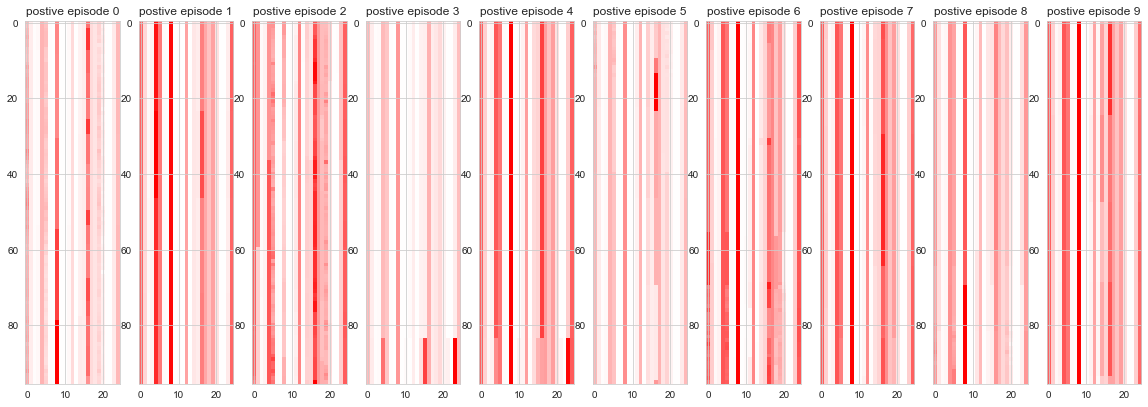

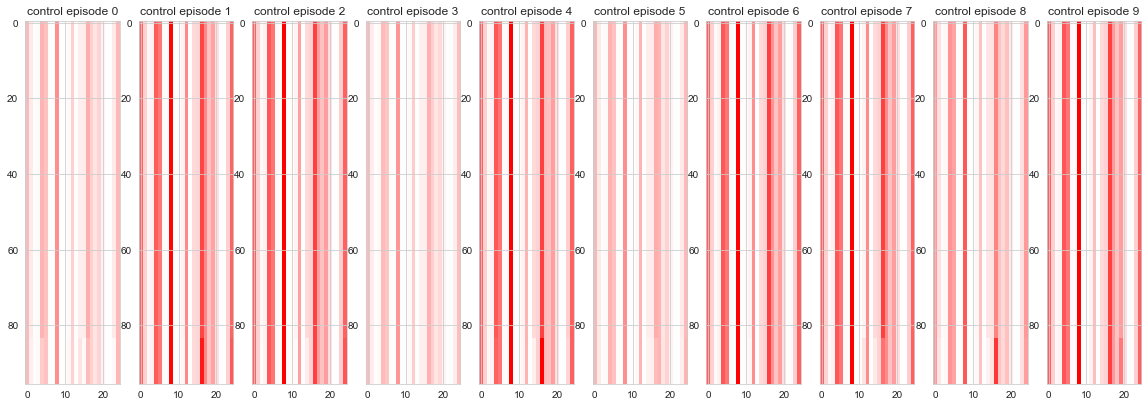

In [9]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0,  # change zero to be not white 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

### 2. Visualize Statistical Moments -- Positive VS Control Group

#### Statistic Moment 1 -- mean

In [ ]:
# outlier in image

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


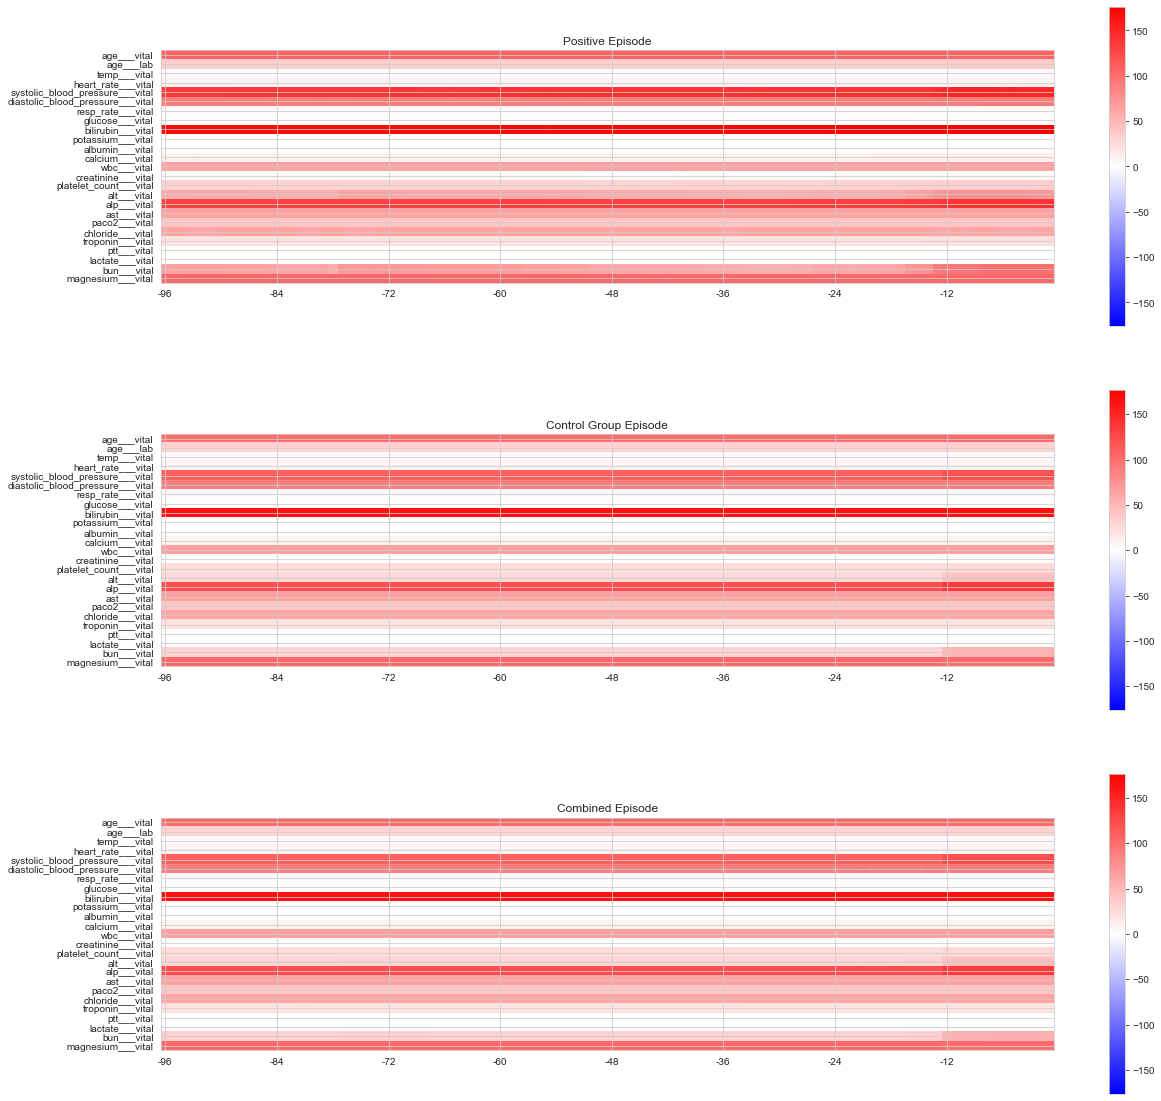

In [10]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 2 -- std

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


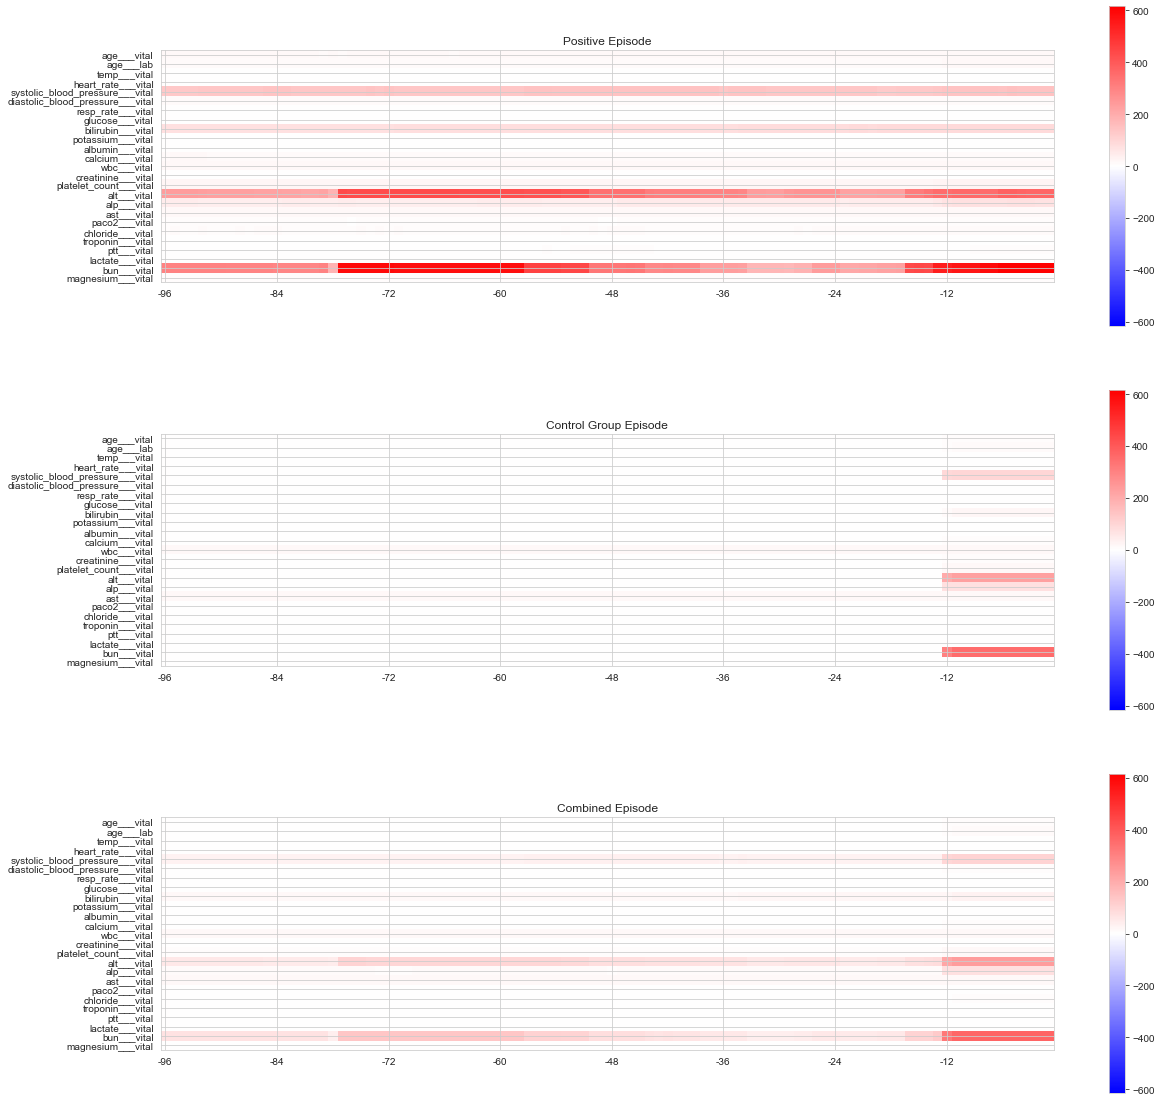

In [11]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 3 -- skewness

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


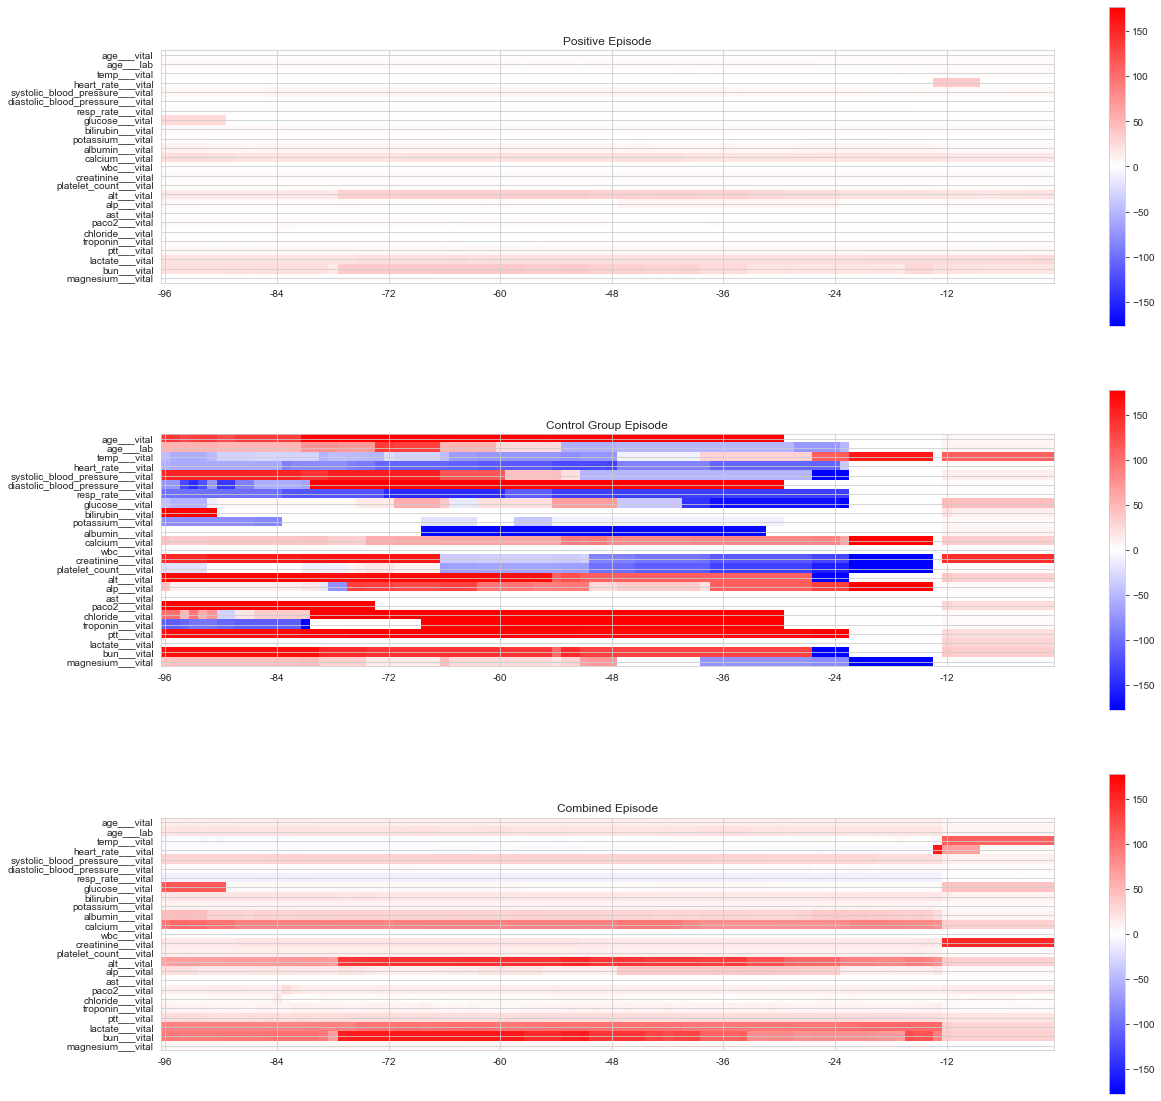

In [12]:
X_pos_stat = scipy.stats.skew(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.skew(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.skew(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 4 -- Kurtosis

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


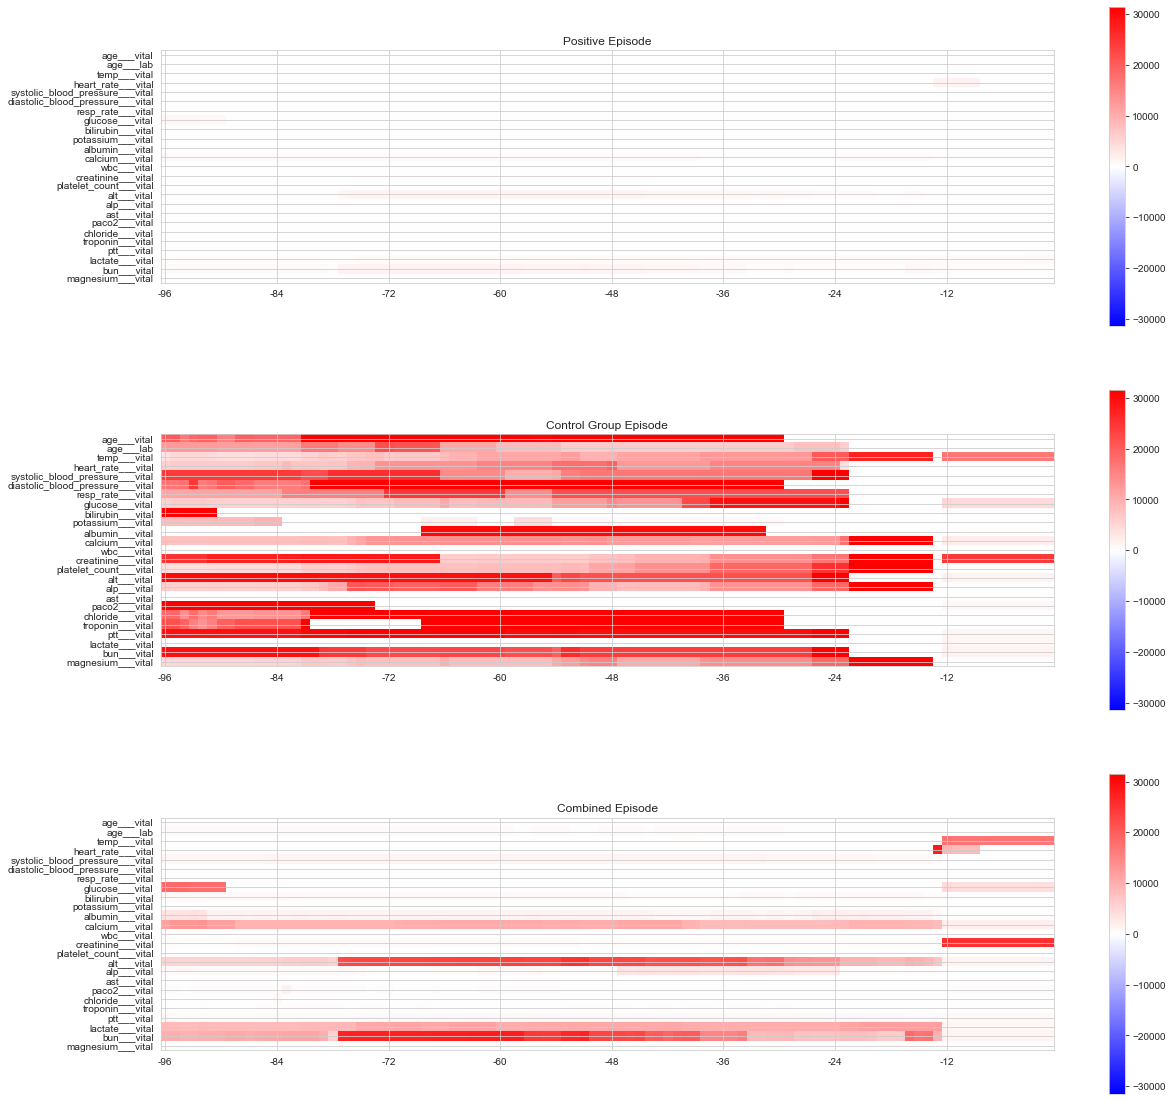

In [13]:
X_pos_stat = scipy.stats.kurtosis(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.kurtosis(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.kurtosis(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

## --- Modeling interpretation raw scale (CNN) ---

In [44]:
X_train_2d = X_train[:,:,:,0].reshape(X_train[:,:,:,0].shape[0],-1)
X_valid_2d = X_valid[:,:,:,0].reshape(X_valid[:,:,:,0].shape[0],-1)
Y_train_binary = Y_train[:,1]
Y_valid_binary = Y_valid[:,1]
print(X_train_2d.shape)
print(Y_train_binary.shape)
print(X_valid_2d.shape)
print(Y_valid_binary.shape)

(23508, 2400)
(23508,)
(6357, 2400)
(6357,)


In [48]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear').fit(X_train_2d, Y_train_binary)

#to check the shape of the coefficient matrix
clf.coef_.shape

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  - multi_class


(1, 2400)

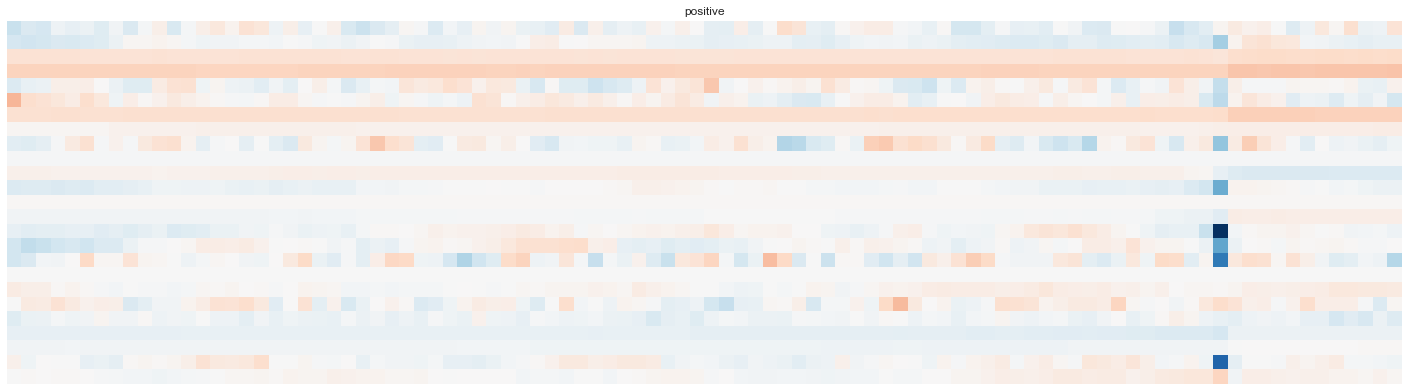

In [49]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 25));
nclasses=1
for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(96, 25).T,
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('positive');

### AUROC for logistic regression

In [53]:
Y_valid_pred = clf.predict_proba(X_valid_2d)
sklearn.metrics.roc_auc_score(Y_valid_binary, Y_valid_pred[:,1])

0.8345297648824412

### binary setup logistic regression

In [19]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2401      
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
735/735 [==============================] - 1s 1ms/step - loss: 7.8654 - AUROC: 0.5674 - AUPRC: 0.1162 - val_loss: 9.4875 - val_AUROC: 0.5278 - val_AUPRC: 0.1225
Epoch 2/50
735/735 [==============================] - 1s 864us/step - loss: 4.0367 - AUROC: 0.6259 - AUPRC: 0.1858 - val_loss: 6.4705 - val_AUROC: 0.5917 - val_AUPRC: 0.2588
Epoch 3/50
735/735 [==============================] - 1s 863us/step - loss: 3.8689 - AUROC: 0.6319 - AUPRC: 0.1882 - val_loss: 3.1467 - val_AUROC: 0.6611 - val_AUPRC: 0.3

### multiple classification setup logistic regression

In [12]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    #keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4802      
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
735/735 [==============================] - 2s 2ms/step - loss: 9.4219 - AUROC: 0.5638 - AUPRC: 0.5244 - val_loss: 13.4031 - val_AUROC: 0.5417 - val_AUPRC: 0.5505
Epoch 2/50
735/735 [==============================] - 1s 1ms/step - loss: 6.5906 - AUROC: 0.6416 - AUPRC: 0.5720 - val_loss: 11.0255 - val_AUROC: 0.5847 - val_AUPRC: 0.5985
Epoch 3/50
735/735 [==============================] - 1s 915us/step - loss: 7.0878 - AUROC: 0.6419 - AUPRC: 0.5761 - val_loss: 6.7965 - val_AUROC: 0.6472 - val_AUPRC: 0.6

In [14]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Conv2D(64, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same',
                        input_shape=list(X_train.shape)[1:4]),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(1, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 25, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 25, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 25, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 25, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 25, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 25, 1)         2

KeyboardInterrupt: 

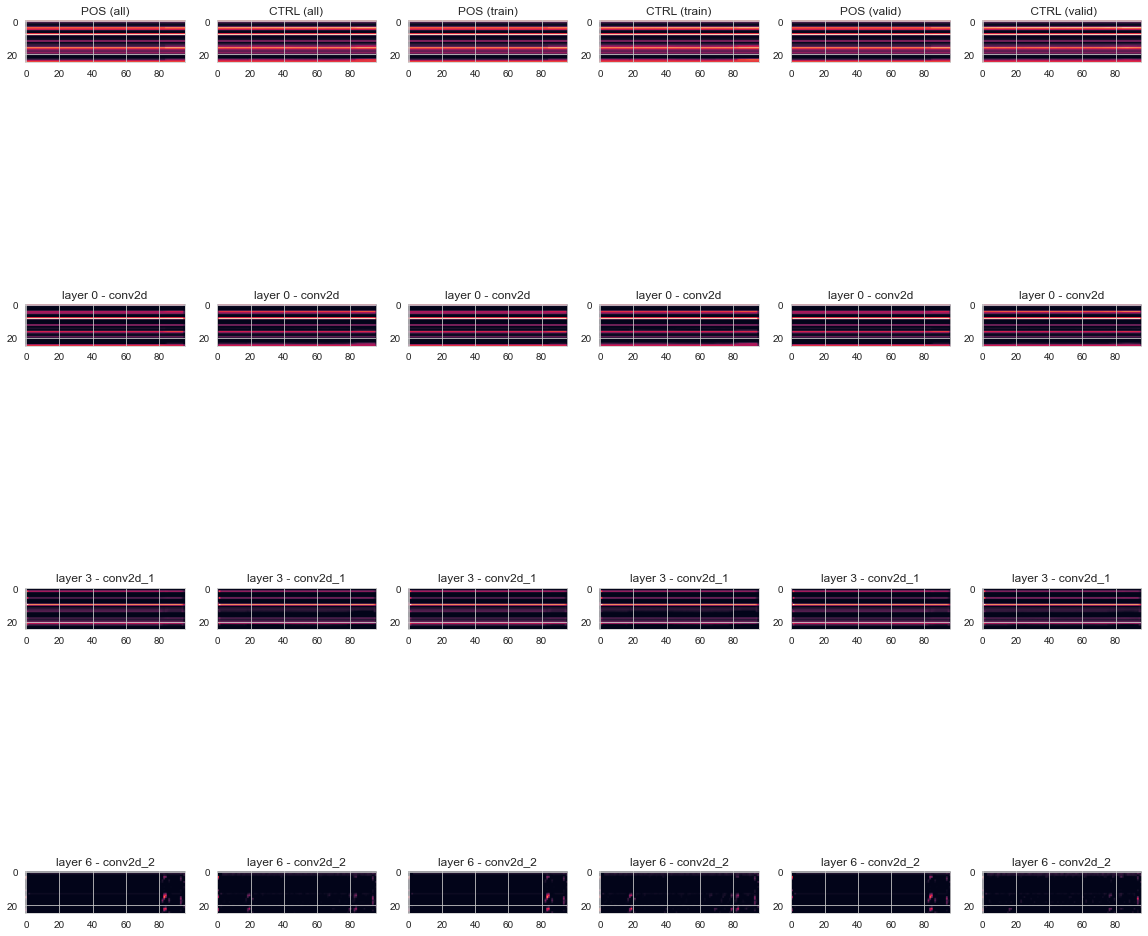

In [15]:
X_train_pos_img = X_train[Y_train[:,0]==1.0].mean(axis=0)
X_train_ctrl_img = X_train[Y_train[:,0]==0.0].mean(axis=0)

X_valid_pos_img = X_valid[Y_valid[:,0]==1.0].mean(axis=0)
X_valid_ctrl_img = X_valid[Y_valid[:,0]==0.0].mean(axis=0)

X_all_pos_img = X_all[Y_all[:,0]==1.0].mean(axis=0)
X_all_ctrl_img = X_all[Y_all[:,0]==0.0].mean(axis=0)

plot_features_map(input_image_list=[X_all_pos_img, X_all_ctrl_img,
                                    X_train_pos_img, X_train_ctrl_img, 
                                    X_valid_pos_img, X_valid_ctrl_img],
                  img_title_list=["POS (all)", "CTRL (all)",
                                  "POS (train)", "CTRL (train)", 
                                  "POS (valid)", " CTRL (valid)"],
                  layer_idx=[0,3,6], 
                  cnn=mdl)

## --- Post-Modeling interpretation (raw scale + saliency map) ---

In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
def plot_saliency(img_idx):
    grads = visualize_saliency(mdl,
                               "visualized_layer",
                               filter_indices=Y_all[img_idx][0], 
                               seed_input=X_all[img_idx], 
                               backprop_modifier=None,
                               grad_modifier="absolute")
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(X_all[img_idx])
    ax[0].set_title('original img id {}'.format(img_idx))
    ax[1].imshow(grads, cmap='jet')
    ax[1].set_title('saliency - predicted {}'.format(img_idx))

plot_saliency(img_idx = 0)

## --- Pre-training Interpretability (standardized) ---

In [16]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_train = (X_train - X_all.mean(axis=0))/X_all.std(axis=0)
X_valid = (X_valid - X_all.mean(axis=0))/X_all.std(axis=0)
X_all = (X_all - X_all.mean(axis=0))/X_all.std(axis=0)

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)


X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


X_train shape (23508, 96, 25, 1)
Y_train shape (23508, 2)
X_valid shape (6357, 96, 25, 1)
Y_valid shape (6357, 2)
X_test shape (3455, 96, 25, 1)
Y_test shape (3455, 2)
X_all shape (33320, 96, 25, 1)
Y_all shape (33320, 2)
X_train shape (23508, 96, 25, 1)
Y_train shape (23508, 2)
X_valid shape (6357, 96, 25, 1)
Y_valid shape (6357, 2)
X_all shape (33320, 96, 25, 1)
Y_all shape (33320, 2)
X_pos shape (1824, 96, 25)
X_ctrl shape (31496, 96, 25)


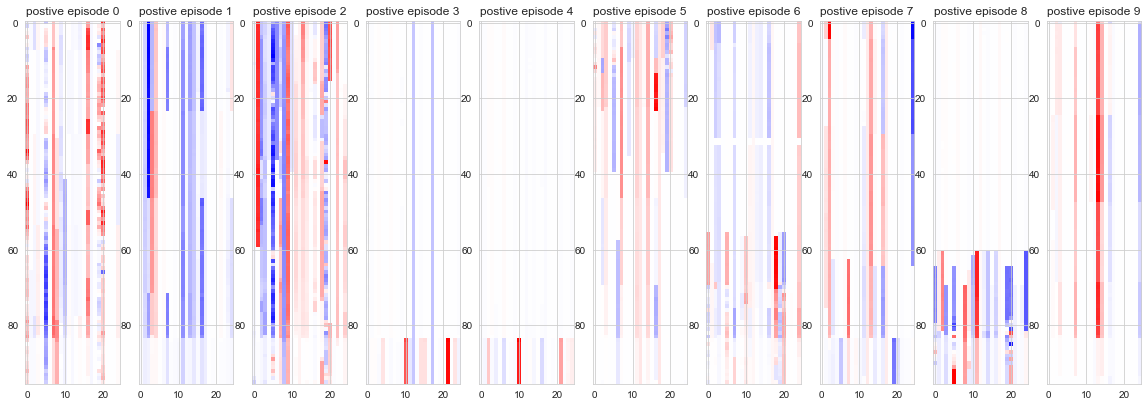

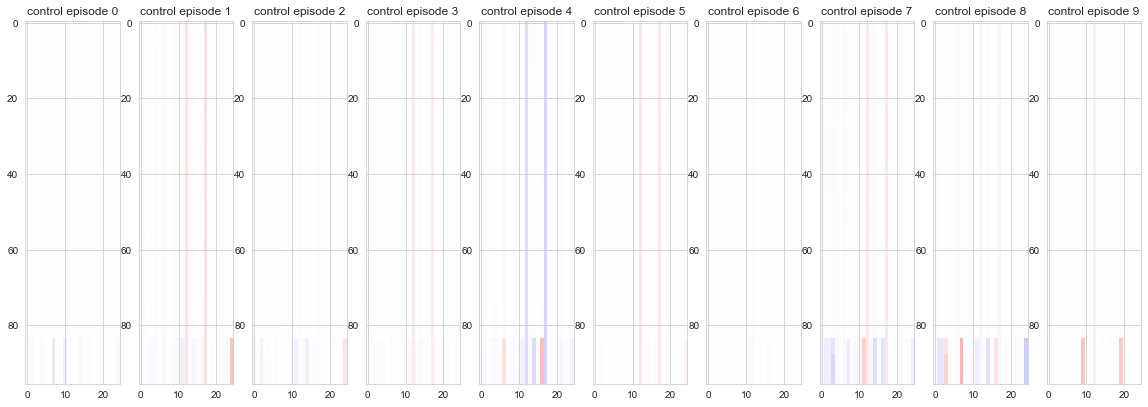

In [17]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

#### Statistic Moment 1 -- mean

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


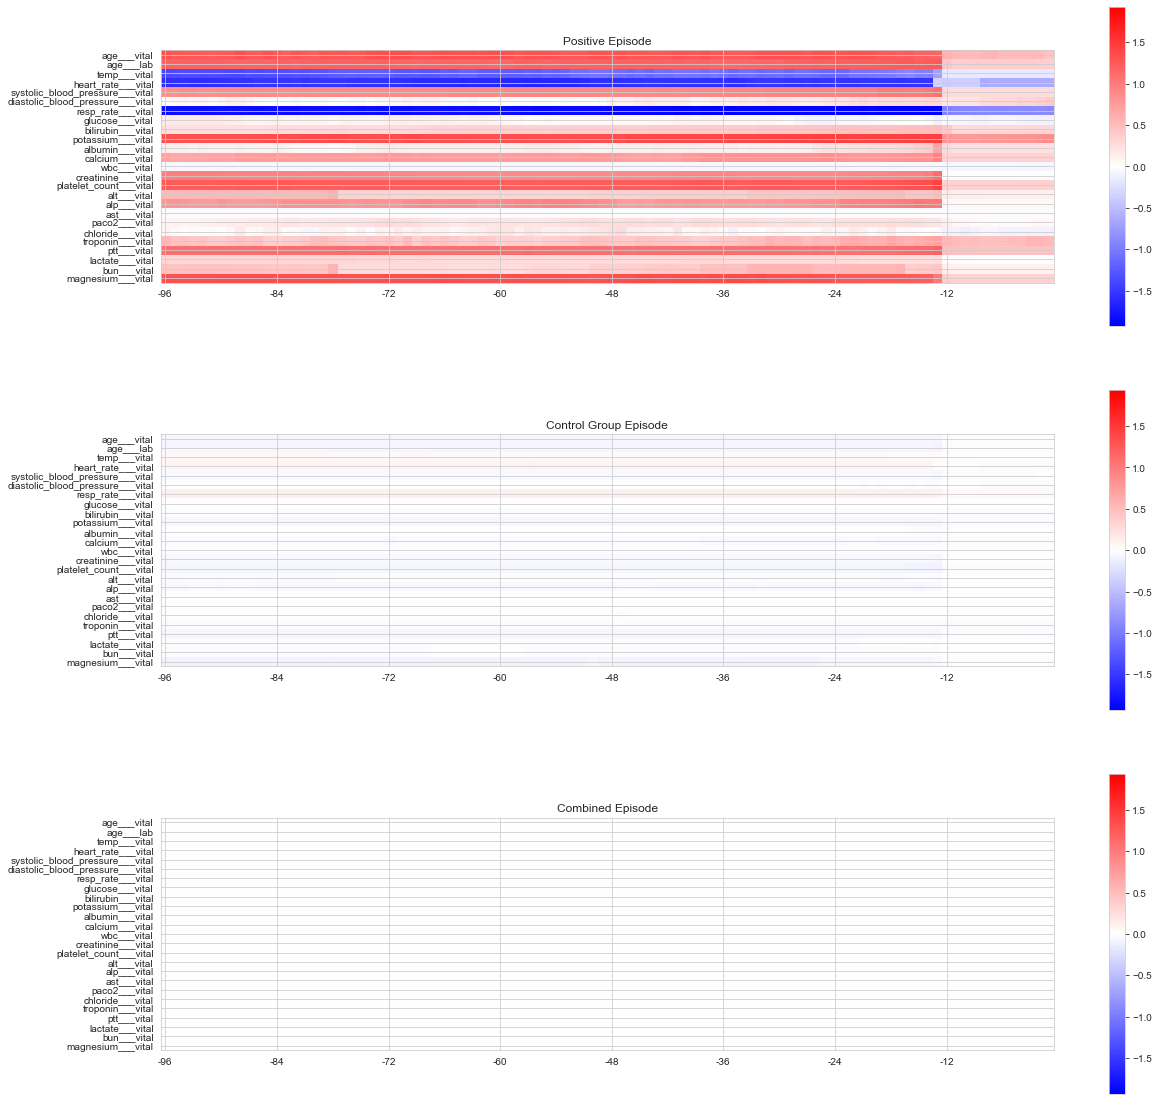

In [18]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


### Statistic Moment 2 -- std

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


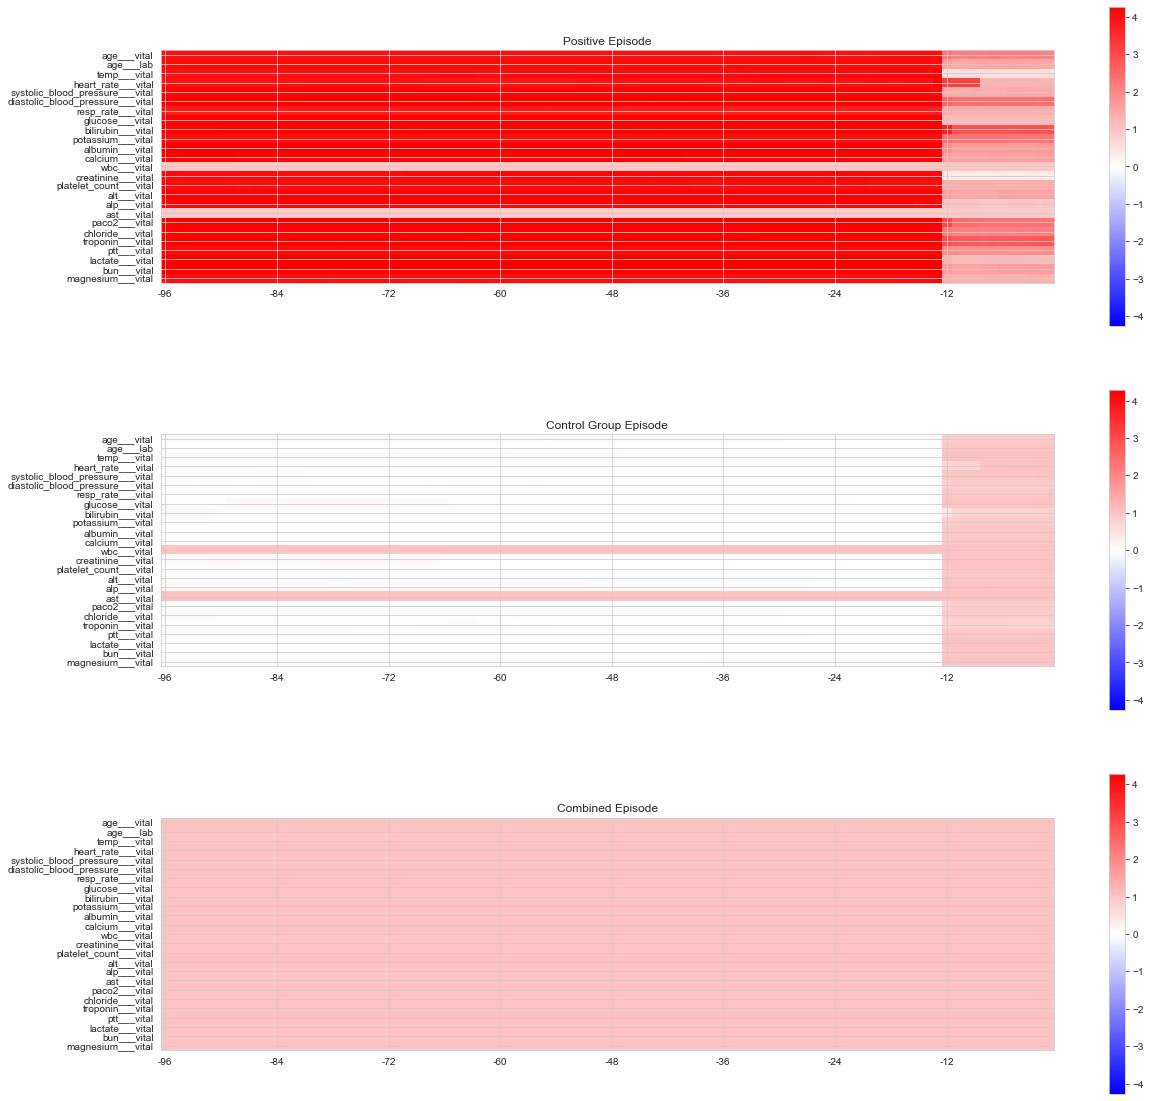

In [19]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 3 -- skewness

#### Statistic Moment 4 -- Kurtosis